## 1. Import Libraries dan Setup
Mengimpor pustaka yang diperlukan dan mengatur seed untuk reproduktibilitas.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
import random
import warnings
import os
warnings.filterwarnings('ignore')

# Set seed untuk reproduktibilitas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

%matplotlib inline

## 2. Definisi Parameter Eksperimen
Mendefinisikan semua parameter yang akan digunakan dalam eksperimen.

In [2]:
# Parameter data
INPUT_FILE = 'data/raw/data_jkse_eda_final.csv'
WINDOW_SIZE = 3
N_SPLITS = 4

# Parameter Algoritma Genetika (GA)
POPULATION_SIZE = 50
GENERATIONS = 100
CROSSOVER_PROB = 0.8
MUTATION_PROB = 0.01
MUTATION_SIGMA = 0.2
TOURNAMENT_SIZE = 4

# Parameter ANN
HIDDEN_NEURONS = 7
LEARNING_RATE = 0.001
INPUT_DIM = 3
DROPOUT_RATE = 0.3
L2_LAMBDA = 0.005

# Parameter pelatihan
EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 5

# Hitung jumlah bobot untuk GA
WEIGHT_COUNT = (INPUT_DIM * HIDDEN_NEURONS +  # W1
                HIDDEN_NEURONS +              # b1
                HIDDEN_NEURONS +              # W2
                1)                            # b2

## 3. Fungsi Utilitas
Mendefinisikan fungsi utilitas yang diperlukan untuk pelatihan, evaluasi, dan visualisasi.

In [3]:
def lr_scheduler(epoch, lr):
    """Scheduler untuk mengurangi learning rate setelah 50 epoch."""
    if epoch > 50:
        return lr * 0.95 ** ((epoch - 50) // 20)
    return lr

def build_ann_model(input_dim, hidden_neurons, use_dropout=False, use_l2=False):
    """Membangun model ANN dengan parameter yang diberikan."""
    initializer = 'glorot_uniform'
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim, activation='relu',
              kernel_initializer=initializer,
              kernel_regularizer=tf.keras.regularizers.l2(L2_LAMBDA) if use_l2 else None),
        Dropout(DROPOUT_RATE) if use_dropout else tf.keras.layers.Lambda(lambda x: x),
        Dense(1, activation='linear',
              kernel_regularizer=tf.keras.regularizers.l2(L2_LAMBDA) if use_l2 else None)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='mse')
    return model

def set_model_weights(model, weights):
    """Mengatur bobot model dari vektor weights untuk GA."""
    w1_size = INPUT_DIM * HIDDEN_NEURONS
    w1 = np.array(weights[:w1_size]).reshape(INPUT_DIM, HIDDEN_NEURONS)
    b1 = np.array(weights[w1_size:w1_size + HIDDEN_NEURONS])
    w2 = np.array(weights[w1_size + HIDDEN_NEURONS:w1_size + 2 * HIDDEN_NEURONS]).reshape(HIDDEN_NEURONS, 1)
    b2 = np.array([weights[-1]])
    model.layers[0].set_weights([w1, b1])
    model.layers[2].set_weights([w2, b2])

def evaluate_individual(individual, model, X, y):
    """Menghitung fitness individu berdasarkan RMSE untuk GA."""
    set_model_weights(model, individual)
    predictions = model.predict(X, verbose=0).flatten()
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return (1.0 / (rmse + 1e-10),)

def calculate_metrics(y_true, y_pred):
    """Menghitung metrik evaluasi (RMSE, MAE, MAPE)."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    return rmse, mae, mape

def denormalize(data, min_val, max_val):
    """Mendenormalisasi data dari [0, 1] ke skala asli."""
    return data * (max_val - min_val) + min_val

def glorot_init(input_dim, hidden_neurons):
    """Membuat inisialisasi bobot dengan rentang Glorot untuk GA."""
    limit_w1 = np.sqrt(6 / (input_dim + hidden_neurons))
    limit_w2 = np.sqrt(6 / (hidden_neurons + 1))
    weights = []
    for _ in range(input_dim * hidden_neurons):
        weights.append(random.uniform(-limit_w1, limit_w1))
    for _ in range(hidden_neurons):
        weights.append(0.0)
    for _ in range(hidden_neurons):
        weights.append(random.uniform(-limit_w2, limit_w2))
    weights.append(0.0)
    return weights

## 4. Load dan Persiapan Data
Memuat data IHSG, normalisasi, dan membuat sliding window.

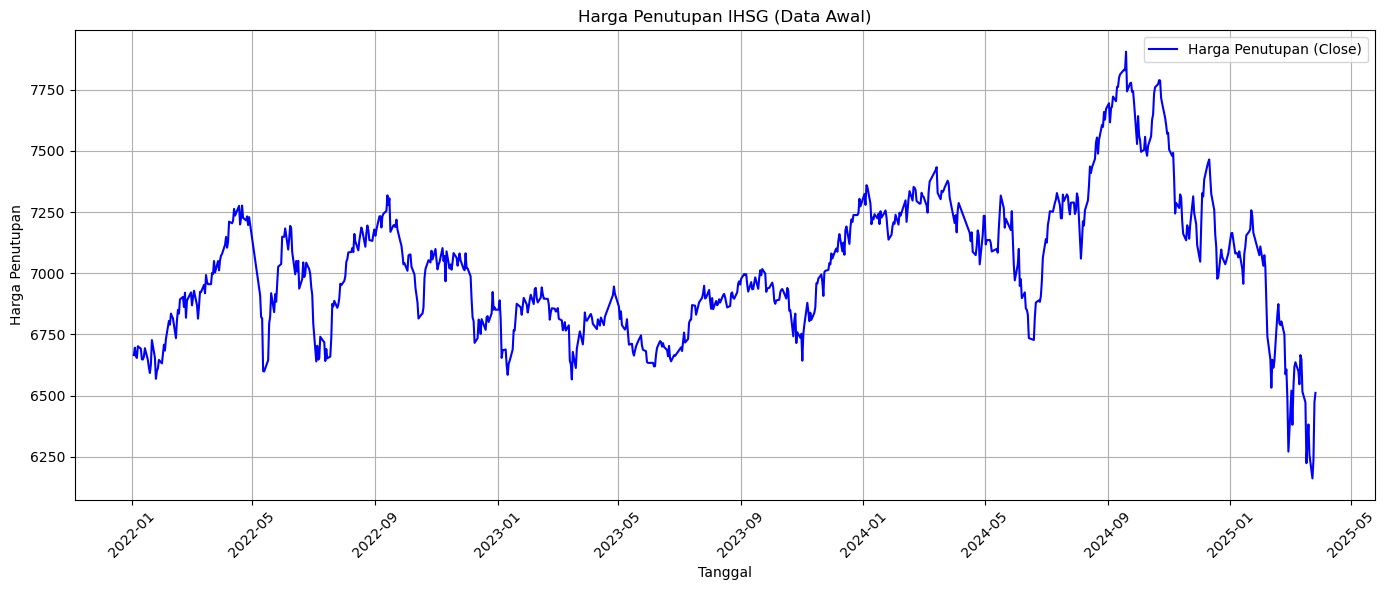

Ukuran fitur X: (779, 3)
Ukuran target y: (779,)


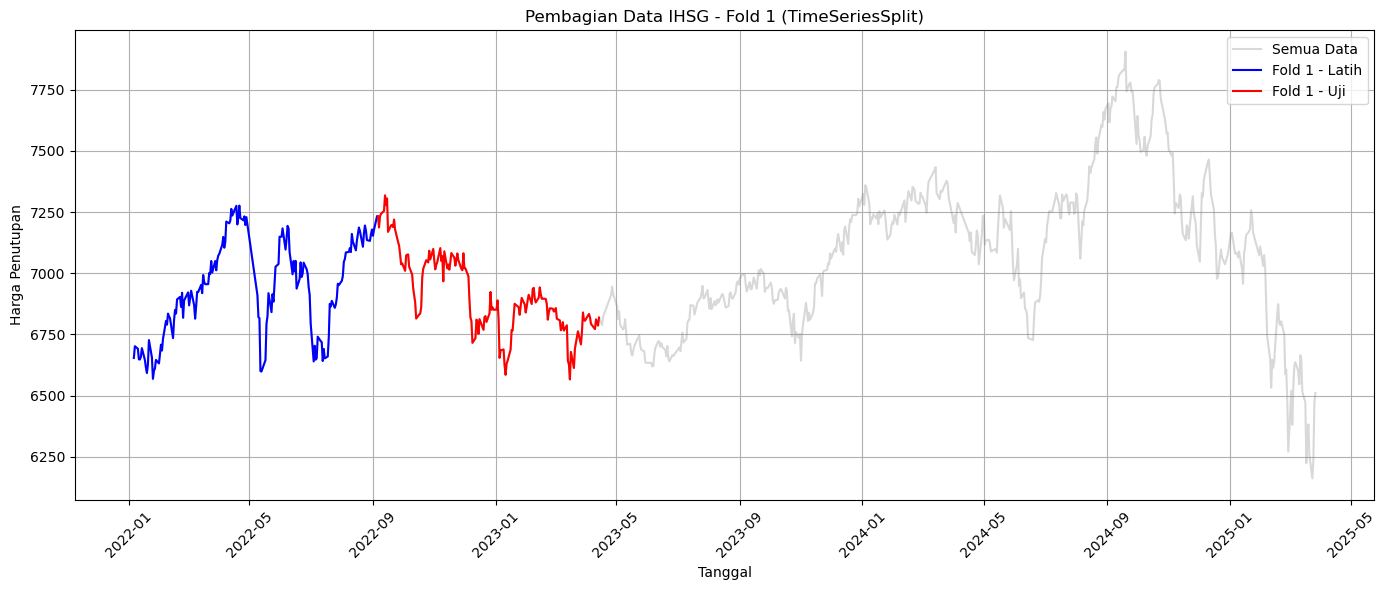

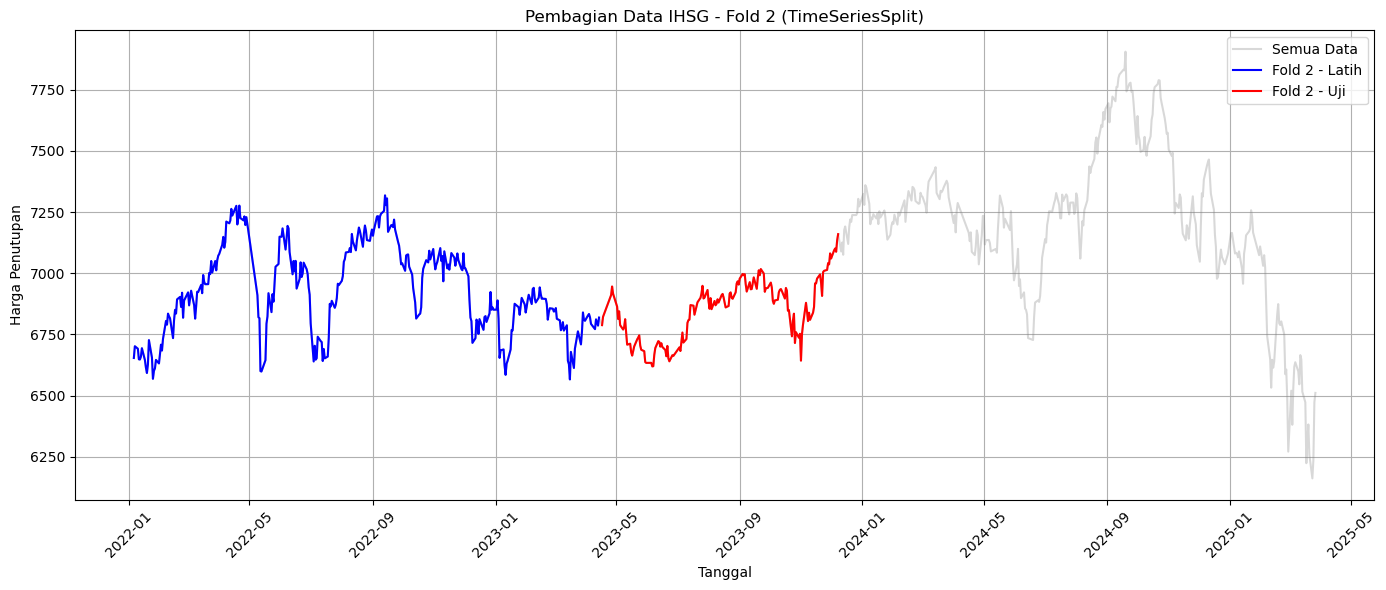

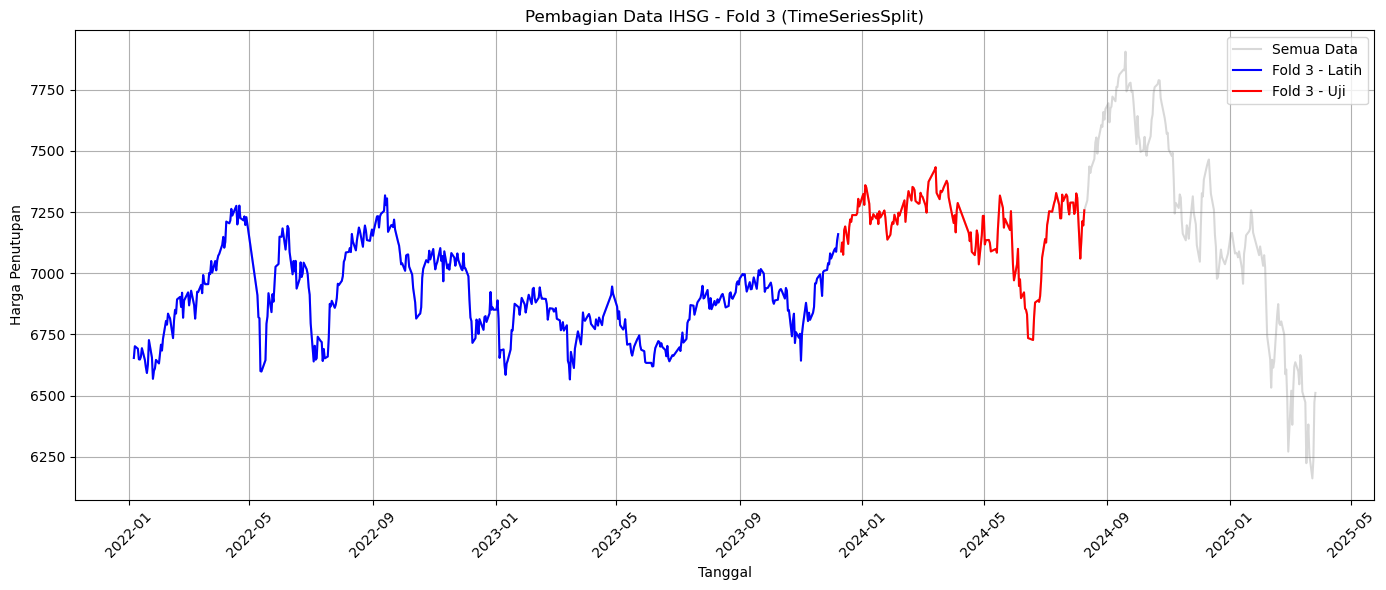

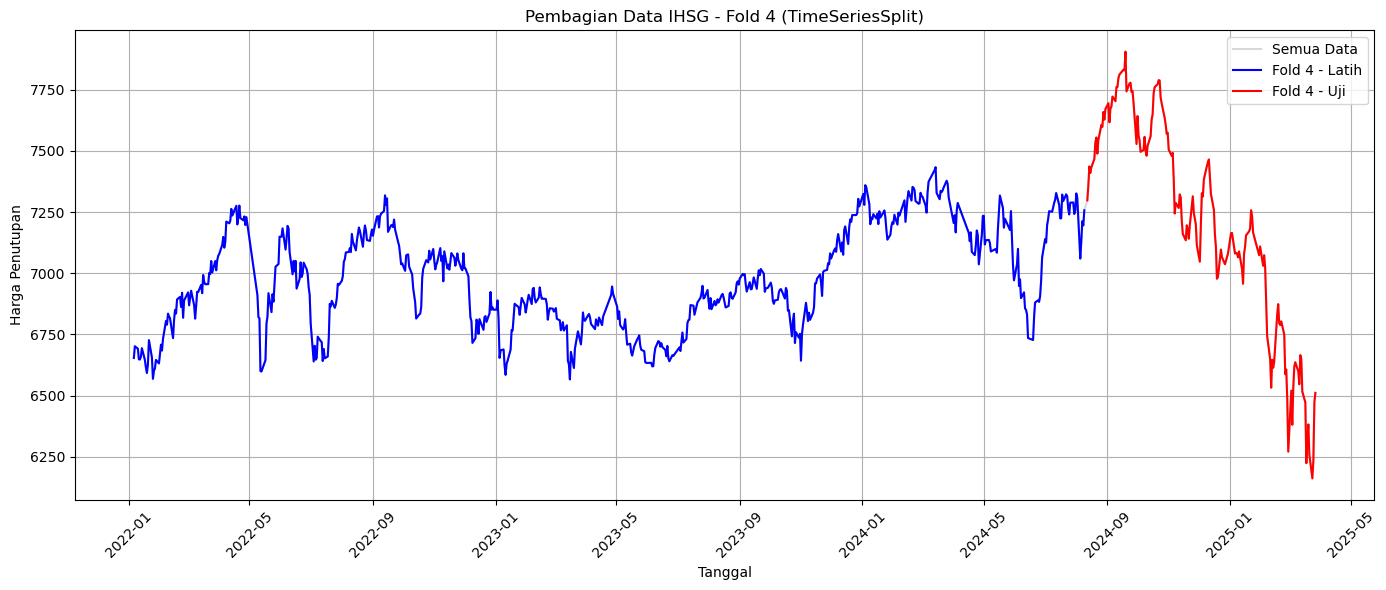

In [4]:
# Load data
df = pd.read_csv(INPUT_FILE, parse_dates=['Date'])
df.sort_values('Date', inplace=True)
dates = df['Date'].values
close_values = df['Close'].values
close_min = close_values.min()
close_max = close_values.max()
close_normalized = (close_values - close_min) / (close_max - close_min)

# Visualisasi data awal
plt.figure(figsize=(14, 6))
plt.plot(dates, close_values, label='Harga Penutupan (Close)', color='blue')
plt.title('Harga Penutupan IHSG (Data Awal)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ihsg_data_initial.png')
plt.show()

# Buat sliding window
X, y = [], []
for i in range(len(close_normalized) - WINDOW_SIZE):
    X.append(close_normalized[i:i + WINDOW_SIZE])
    y.append(close_normalized[i + WINDOW_SIZE])
X = np.array(X)
y = np.array(y)
dates = dates[WINDOW_SIZE:]
close_values = close_values[WINDOW_SIZE:]
print(f"Ukuran fitur X: {X.shape}")
print(f"Ukuran target y: {y.shape}")

# Buat pembagian fold dengan TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]
    train_close = close_values[train_idx]
    test_close = close_values[test_idx]
    
    plt.figure(figsize=(14, 6))
    plt.plot(dates, close_values, color='gray', alpha=0.3, label='Semua Data')
    plt.plot(train_dates, train_close, color='blue', label=f'Fold {fold} - Latih')
    plt.plot(test_dates, test_close, color='red', label=f'Fold {fold} - Uji')
    plt.title(f'Pembagian Data IHSG - Fold {fold} (TimeSeriesSplit)')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'ihsg_fold_{fold}_split.png')
    plt.show()

## 5. Setup dan Pelatihan GANN per Fold
Menggunakan Algoritma Genetika (mengunakan library DEAP) untuk mengoptimalkan bobot ANN tanpa pelatihan lanjutan.


=== Melatih GANN Fold 1 ===
Generasi 1: Rata-rata Fitness (1/RMSE) = 5.952439, Maksimum Fitness (1/RMSE) = 18.007383
Generasi 2: Rata-rata Fitness (1/RMSE) = 13.029453, Maksimum Fitness (1/RMSE) = 26.123321
Generasi 3: Rata-rata Fitness (1/RMSE) = 14.841506, Maksimum Fitness (1/RMSE) = 26.123321
Generasi 4: Rata-rata Fitness (1/RMSE) = 17.987907, Maksimum Fitness (1/RMSE) = 26.123321
Generasi 5: Rata-rata Fitness (1/RMSE) = 19.057263, Maksimum Fitness (1/RMSE) = 26.123321
Generasi 6: Rata-rata Fitness (1/RMSE) = 22.208993, Maksimum Fitness (1/RMSE) = 26.123321
Generasi 7: Rata-rata Fitness (1/RMSE) = 22.176033, Maksimum Fitness (1/RMSE) = 26.710271
Generasi 8: Rata-rata Fitness (1/RMSE) = 25.299997, Maksimum Fitness (1/RMSE) = 26.915537
Generasi 9: Rata-rata Fitness (1/RMSE) = 26.614328, Maksimum Fitness (1/RMSE) = 27.478579
Generasi 10: Rata-rata Fitness (1/RMSE) = 26.983481, Maksimum Fitness (1/RMSE) = 27.478579
Generasi 11: Rata-rata Fitness (1/RMSE) = 27.253362, Maksimum Fitness (

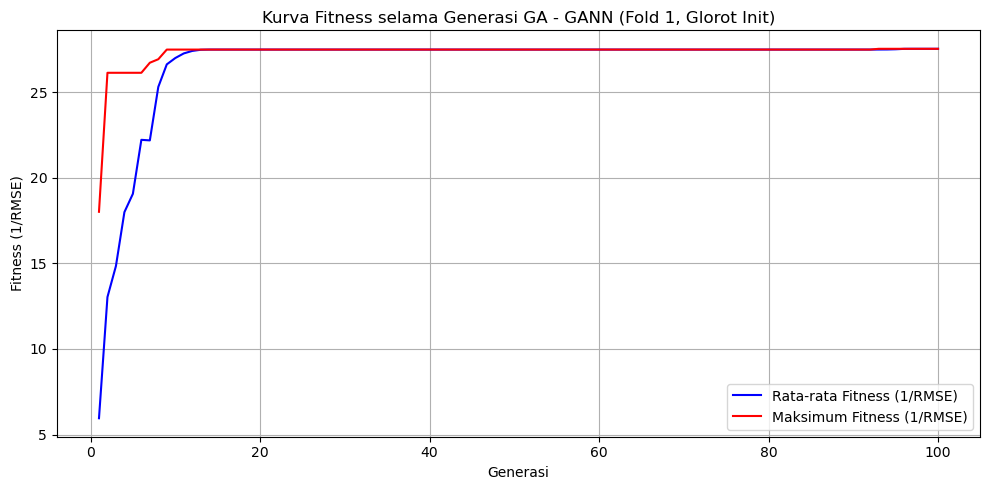


=== Melatih GANN Fold 2 ===
Generasi 1: Rata-rata Fitness (1/RMSE) = 8.474506, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 2: Rata-rata Fitness (1/RMSE) = 15.192994, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 3: Rata-rata Fitness (1/RMSE) = 18.625396, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 4: Rata-rata Fitness (1/RMSE) = 21.990679, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 5: Rata-rata Fitness (1/RMSE) = 25.402000, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 6: Rata-rata Fitness (1/RMSE) = 27.983981, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 7: Rata-rata Fitness (1/RMSE) = 28.730683, Maksimum Fitness (1/RMSE) = 28.939617
Generasi 8: Rata-rata Fitness (1/RMSE) = 28.763612, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 9: Rata-rata Fitness (1/RMSE) = 28.763612, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 10: Rata-rata Fitness (1/RMSE) = 28.763612, Maksimum Fitness (1/RMSE) = 28.763612
Generasi 11: Rata-rata Fitness (1/RMSE) = 28.763612, Maksimum Fitness (

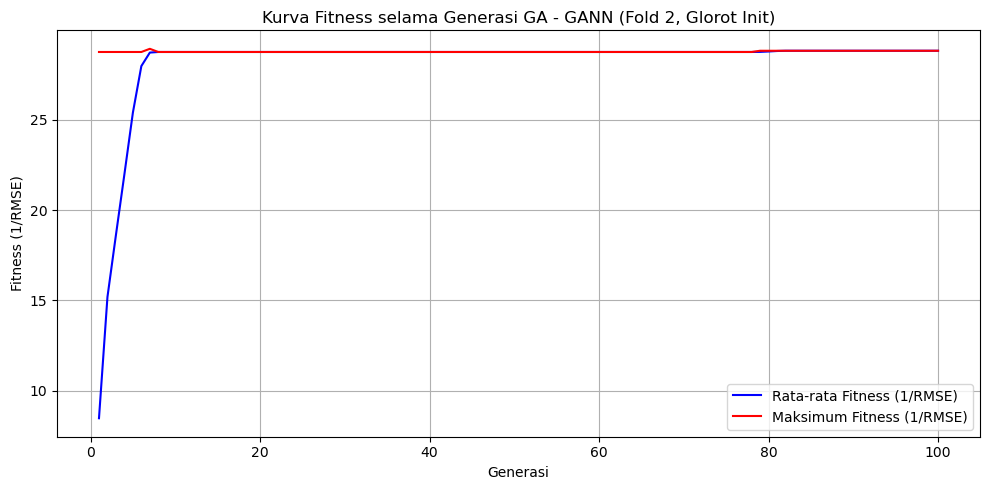


=== Melatih GANN Fold 3 ===
Generasi 1: Rata-rata Fitness (1/RMSE) = 11.082411, Maksimum Fitness (1/RMSE) = 31.641963
Generasi 2: Rata-rata Fitness (1/RMSE) = 18.226483, Maksimum Fitness (1/RMSE) = 30.921023
Generasi 3: Rata-rata Fitness (1/RMSE) = 26.928067, Maksimum Fitness (1/RMSE) = 32.707424
Generasi 4: Rata-rata Fitness (1/RMSE) = 30.209692, Maksimum Fitness (1/RMSE) = 32.707424
Generasi 5: Rata-rata Fitness (1/RMSE) = 30.578400, Maksimum Fitness (1/RMSE) = 32.373785
Generasi 6: Rata-rata Fitness (1/RMSE) = 31.837042, Maksimum Fitness (1/RMSE) = 34.496492
Generasi 7: Rata-rata Fitness (1/RMSE) = 32.971471, Maksimum Fitness (1/RMSE) = 34.496492
Generasi 8: Rata-rata Fitness (1/RMSE) = 33.817226, Maksimum Fitness (1/RMSE) = 34.496492
Generasi 9: Rata-rata Fitness (1/RMSE) = 34.496492, Maksimum Fitness (1/RMSE) = 34.496492
Generasi 10: Rata-rata Fitness (1/RMSE) = 34.496492, Maksimum Fitness (1/RMSE) = 34.496492
Generasi 11: Rata-rata Fitness (1/RMSE) = 34.496492, Maksimum Fitness 

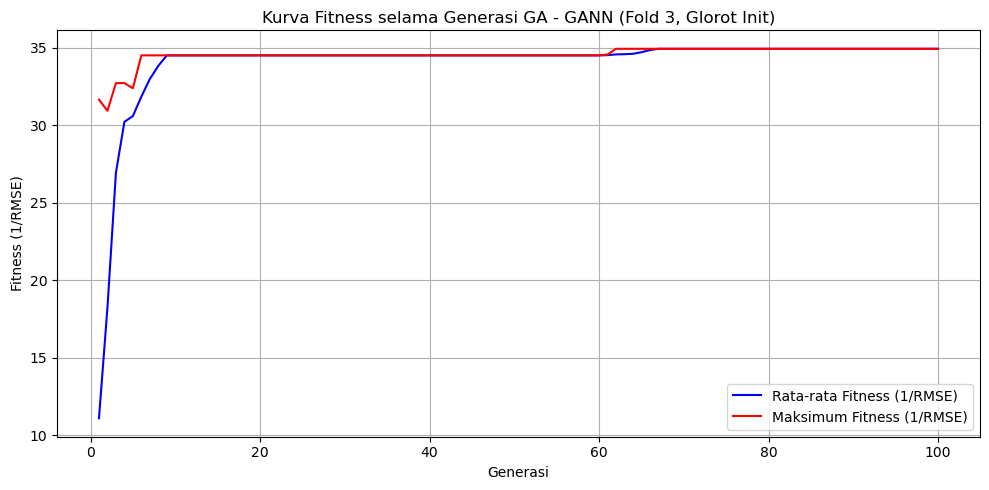


=== Melatih GANN Fold 4 ===
Generasi 1: Rata-rata Fitness (1/RMSE) = 9.256115, Maksimum Fitness (1/RMSE) = 28.236129
Generasi 2: Rata-rata Fitness (1/RMSE) = 14.825205, Maksimum Fitness (1/RMSE) = 28.236129
Generasi 3: Rata-rata Fitness (1/RMSE) = 20.017266, Maksimum Fitness (1/RMSE) = 30.085036
Generasi 4: Rata-rata Fitness (1/RMSE) = 24.656363, Maksimum Fitness (1/RMSE) = 30.085036
Generasi 5: Rata-rata Fitness (1/RMSE) = 27.701815, Maksimum Fitness (1/RMSE) = 30.085036
Generasi 6: Rata-rata Fitness (1/RMSE) = 29.438965, Maksimum Fitness (1/RMSE) = 30.245963
Generasi 7: Rata-rata Fitness (1/RMSE) = 29.907308, Maksimum Fitness (1/RMSE) = 30.245963
Generasi 8: Rata-rata Fitness (1/RMSE) = 30.234344, Maksimum Fitness (1/RMSE) = 30.800768
Generasi 9: Rata-rata Fitness (1/RMSE) = 30.391653, Maksimum Fitness (1/RMSE) = 30.800768
Generasi 10: Rata-rata Fitness (1/RMSE) = 30.634327, Maksimum Fitness (1/RMSE) = 30.800768
Generasi 11: Rata-rata Fitness (1/RMSE) = 30.789672, Maksimum Fitness (

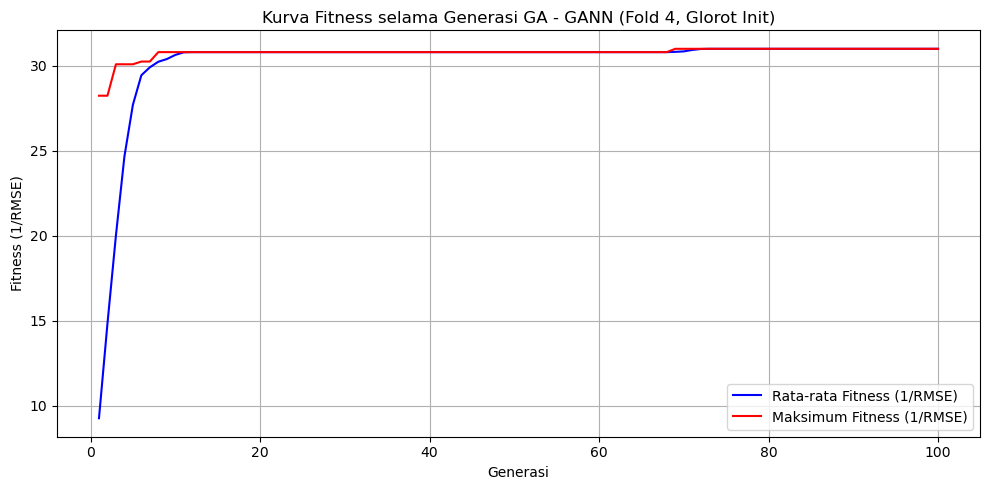

In [5]:
# Bagian 6: Pelatihan GANN per Fold
# Inisialisasi untuk menyimpan hasil
gann_metrics = []
gann_predictions_per_fold = []
gann_best_weights = []

# Setup GA untuk GANN
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", glorot_init, INPUT_DIM, HIDDEN_NEURONS)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=MUTATION_SIGMA, indpb=MUTATION_PROB)
# toolbox.register("select", tools.selRoulette)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Buat direktori untuk menyimpan model jika belum ada
os.makedirs('models', exist_ok=True)

# Loop untuk setiap fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n=== Melatih GANN Fold {fold} ===")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_close = close_values[train_idx]
    test_close = close_values[test_idx]
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]

    # Buat model untuk GA
    model = build_ann_model(INPUT_DIM, HIDDEN_NEURONS, use_dropout=False, use_l2=False)

    # Register fungsi evaluasi
    toolbox.register("evaluate", evaluate_individual, model=model, X=X_train, y=y_train)

    # Jalankan GA
    population = toolbox.population(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    hof = tools.HallOfFame(1)

    # List untuk menyimpan fitness per generasi
    fitness_avg_history = []
    fitness_max_history = []

    for gen in range(GENERATIONS):
        population = algorithms.varAnd(population, toolbox, cxpb=CROSSOVER_PROB, mutpb=MUTATION_PROB)
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        hof.update(population)
        population = toolbox.select(population, len(population))
        record = stats.compile(population)
        fitness_avg_history.append(record['avg'])
        fitness_max_history.append(record['max'])
        print(f"Generasi {gen + 1}: Rata-rata Fitness (1/RMSE) = {record['avg']:.6f}, Maksimum Fitness (1/RMSE) = {record['max']:.6f}")

    # Visualisasi kurva fitness
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, GENERATIONS + 1), fitness_avg_history, label='Rata-rata Fitness (1/RMSE)', color='blue')
    plt.plot(range(1, GENERATIONS + 1), fitness_max_history, label='Maksimum Fitness (1/RMSE)', color='red')
    plt.title(f'Kurva Fitness selama Generasi GA - GANN (Fold {fold}, Glorot Init)')
    plt.xlabel('Generasi')
    plt.ylabel('Fitness (1/RMSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'ihsg_fitness_curve_gann_fold_{fold}_glorot.png')
    plt.show()

    best_weights = hof[0]
    gann_best_weights.append(best_weights)

    # Prediksi
    set_model_weights(model, best_weights)
    gann_predictions = model.predict(np.concatenate([X_train, X_test]), verbose=0).flatten()
    gann_predictions_denorm = denormalize(gann_predictions, close_min, close_max)

    # Simpan model
    model.save(f'models/gann_fold_{fold}.keras')

    # Simpan prediksi
    fold_pred_df = pd.DataFrame({
        'Fold': fold,
        'Date': np.concatenate([train_dates, test_dates]),
        'Actual_Close': np.concatenate([train_close, test_close]),
        'Predicted_GANN': gann_predictions_denorm,
        'Data': ['Latih'] * len(train_dates) + ['Uji'] * len(test_dates)
    })
    gann_predictions_per_fold.append(fold_pred_df)

    # Bersihkan memori
    import gc
    gc.collect()
    tf.keras.backend.clear_session()

#### Penggunaan `gc.collect()` untuk Mengatasi Masalah Memori

Dalam proses pelatihan model pada kode ini, pernah terjadi masalah di mana proses terhenti (stuck) saat menjalankan pelatihan dengan 150 generasi, terutama karena penggunaan memori backend yang sangat besar oleh TensorFlow/Keras. Untuk mengatasi masalah ini, fungsi `gc.collect()` dari modul `gc` (garbage collector) Python digunakan untuk membersihkan memori secara manual setelah setiap fold selesai diproses. 

Fungsi `gc.collect()` bekerja dengan membebaskan memori dari objek yang tidak lagi memiliki referensi aktif, seperti array sementara atau model yang sudah tidak digunakan. Namun, penggunaan `gc.collect()` ini **tidak memengaruhi referensi atau variabel aktif** seperti `fold_pred_df`, yang disimpan dalam list seperti `gann_predictions_per_fold`, `gadam_predictions_per_fold`, dan `adam_predictions_per_fold`. Dengan demikian, data penting tetap aman, sementara memori yang tidak diperlukan dapat dibersihkan untuk mencegah kebocoran memori (memory leak), memastikan proses pelatihan berjalan lancar hingga selesai, bahkan untuk konfigurasi dengan 150 generasi.

## 6. Validasi GANN per Fold
Mengevaluasi performa GANN pada setiap fold dan membuat visualisasi.


=== Validasi GANN Fold 1 ===


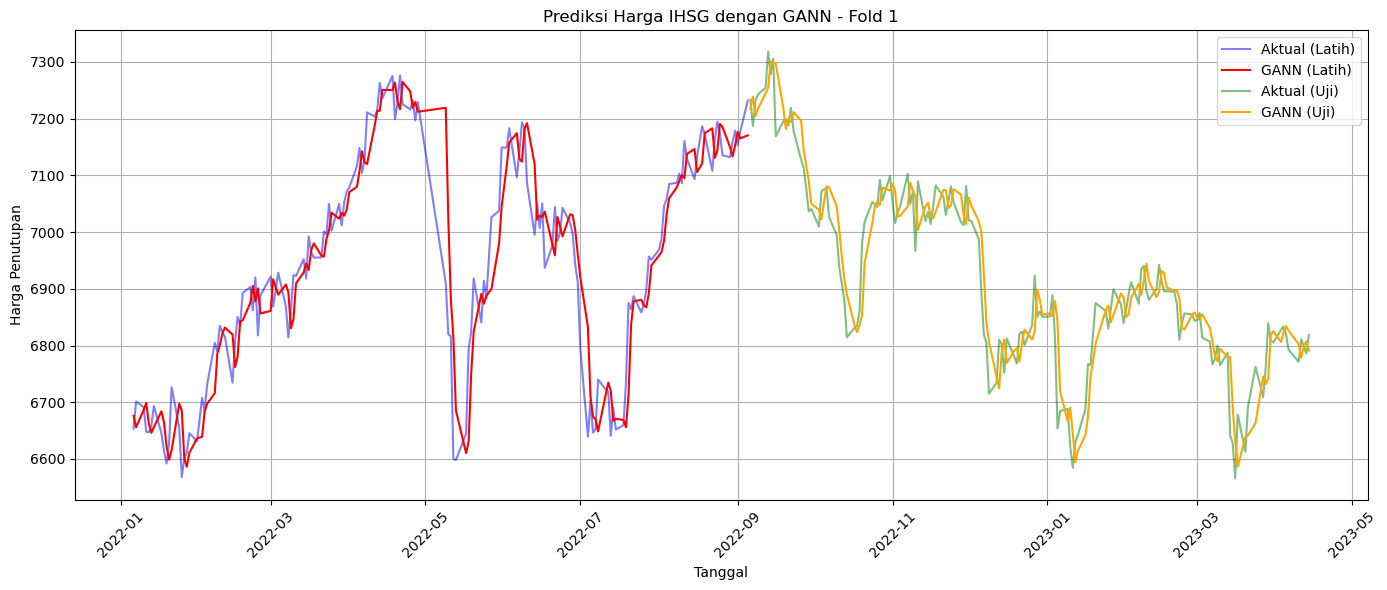


=== Validasi GANN Fold 2 ===


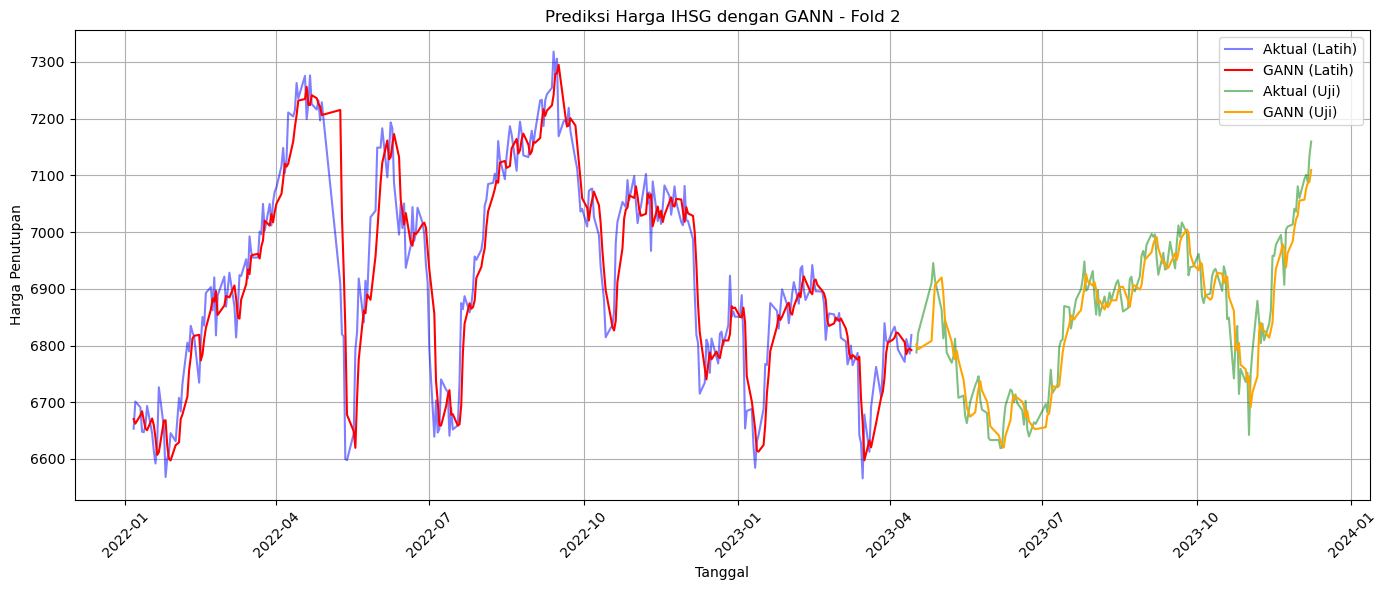


=== Validasi GANN Fold 3 ===


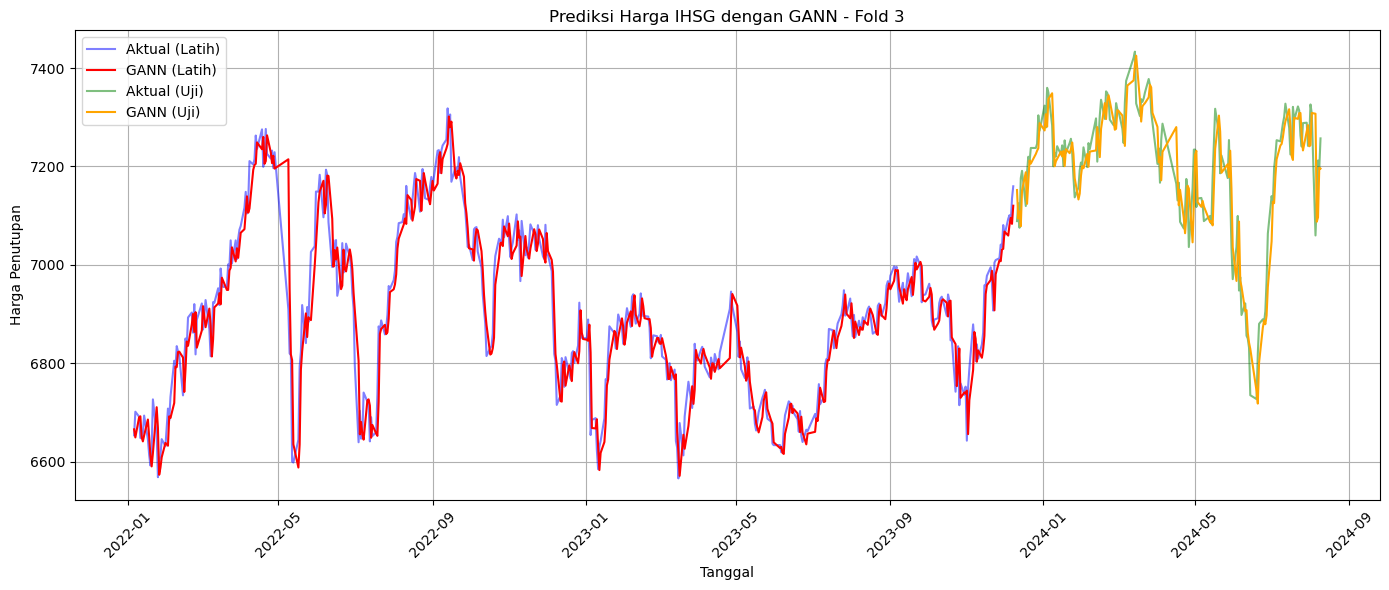


=== Validasi GANN Fold 4 ===


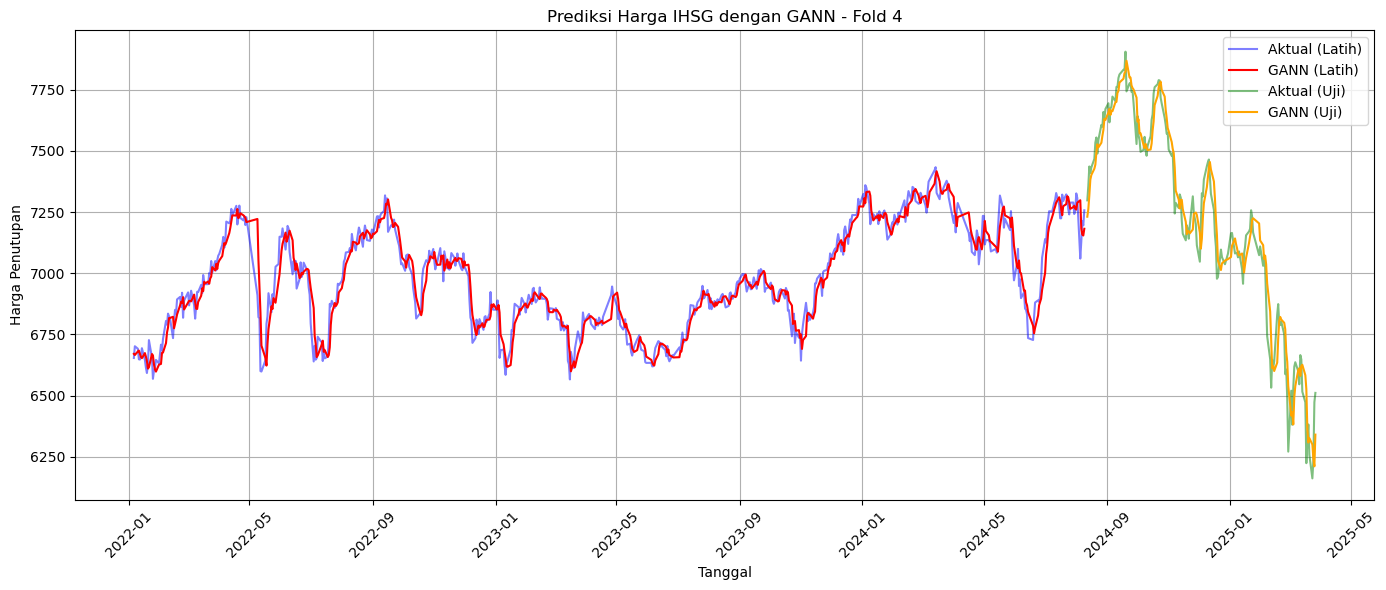

In [6]:
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n=== Validasi GANN Fold {fold} ===")
    train_close = close_values[train_idx]
    test_close = close_values[test_idx]
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]

    # Ambil prediksi
    fold_pred_df = gann_predictions_per_fold[fold-1]
    gann_pred = fold_pred_df['Predicted_GANN'].values
    train_pred = gann_pred[:len(train_close)]
    test_pred = gann_pred[len(train_close):]

    # Hitung metrik
    rmse_train, mae_train, mape_train = calculate_metrics(train_close, train_pred)
    rmse_test, mae_test, mape_test = calculate_metrics(test_close, test_pred)
    gann_metrics.append({'Fold': fold, 'Data': 'Latih', 'RMSE': rmse_train, 'MAE': mae_train, 'MAPE': mape_train})
    gann_metrics.append({'Fold': fold, 'Data': 'Uji', 'RMSE': rmse_test, 'MAE': mae_test, 'MAPE': mape_test})

    # Visualisasi prediksi vs aktual
    plt.figure(figsize=(14, 6))
    plt.plot(train_dates, train_close, label='Aktual (Latih)', color='blue', alpha=0.5)
    plt.plot(train_dates, train_pred, label='GANN (Latih)', color='red')
    plt.plot(test_dates, test_close, label='Aktual (Uji)', color='green', alpha=0.5)
    plt.plot(test_dates, test_pred, label='GANN (Uji)', color='orange')
    plt.title(f'Prediksi Harga IHSG dengan GANN - Fold {fold}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'ihsg_prediction_gann_fold_{fold}_glorot.png')
    plt.show()

## 7. Setup dan Pelatihan GADAM per Fold
Menggunakan Algoritma Genetika (mengunakan library DEAP) untuk mengoptimalkan bobot awal, kemudian melatih dengan ADAM.


=== Melatih GADAM Fold 1 ===
Generasi 1: Rata-rata Fitness (1/RMSE) = 9.741687, Maksimum Fitness (1/RMSE) = 28.582966
Generasi 2: Rata-rata Fitness (1/RMSE) = 14.350076, Maksimum Fitness (1/RMSE) = 28.582966
Generasi 3: Rata-rata Fitness (1/RMSE) = 17.654761, Maksimum Fitness (1/RMSE) = 28.582966
Generasi 4: Rata-rata Fitness (1/RMSE) = 19.133597, Maksimum Fitness (1/RMSE) = 27.365987
Generasi 5: Rata-rata Fitness (1/RMSE) = 21.254044, Maksimum Fitness (1/RMSE) = 27.365987
Generasi 6: Rata-rata Fitness (1/RMSE) = 20.825900, Maksimum Fitness (1/RMSE) = 26.505703
Generasi 7: Rata-rata Fitness (1/RMSE) = 24.120153, Maksimum Fitness (1/RMSE) = 26.505703
Generasi 8: Rata-rata Fitness (1/RMSE) = 25.252426, Maksimum Fitness (1/RMSE) = 26.505703
Generasi 9: Rata-rata Fitness (1/RMSE) = 25.330336, Maksimum Fitness (1/RMSE) = 27.365987
Generasi 10: Rata-rata Fitness (1/RMSE) = 26.207421, Maksimum Fitness (1/RMSE) = 27.365987
Generasi 11: Rata-rata Fitness (1/RMSE) = 26.655049, Maksimum Fitness 

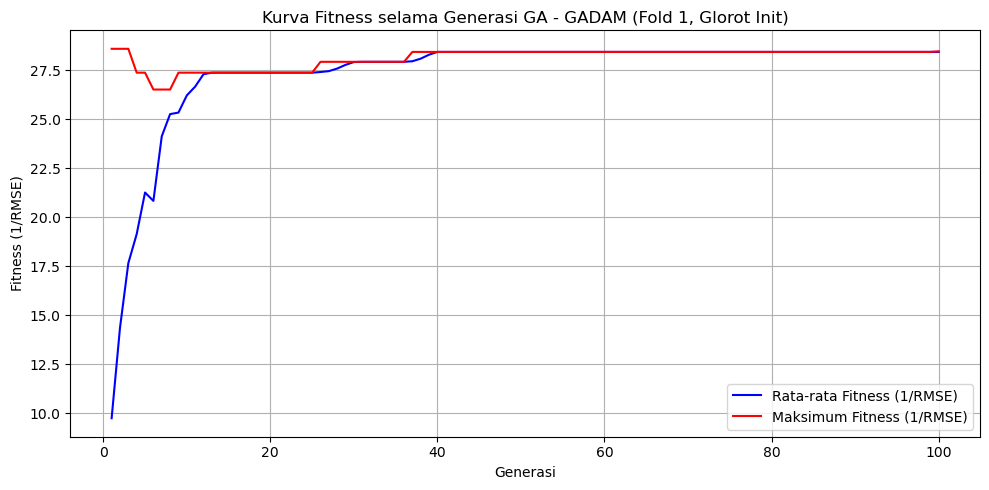

Fold 1 - GADAM - Epoch 1: Loss Latih = 0.001236, Loss Validasi = 0.000725
Fold 1 - GADAM - Epoch 2: Loss Latih = 0.001211, Loss Validasi = 0.000755
Fold 1 - GADAM - Epoch 3: Loss Latih = 0.001219, Loss Validasi = 0.000735
Fold 1 - GADAM - Epoch 4: Loss Latih = 0.001211, Loss Validasi = 0.000722
Fold 1 - GADAM - Epoch 5: Loss Latih = 0.001204, Loss Validasi = 0.000727
Fold 1 - GADAM - Epoch 6: Loss Latih = 0.001201, Loss Validasi = 0.000734
Fold 1 - GADAM - Epoch 7: Loss Latih = 0.001202, Loss Validasi = 0.000727
Fold 1 - GADAM - Epoch 8: Loss Latih = 0.001199, Loss Validasi = 0.000721
Fold 1 - GADAM - Epoch 9: Loss Latih = 0.001196, Loss Validasi = 0.000723
Fold 1 - GADAM - Epoch 10: Loss Latih = 0.001194, Loss Validasi = 0.000726
Fold 1 - GADAM - Epoch 11: Loss Latih = 0.001194, Loss Validasi = 0.000723
Fold 1 - GADAM - Epoch 12: Loss Latih = 0.001193, Loss Validasi = 0.000721
Fold 1 - GADAM - Epoch 13: Loss Latih = 0.001191, Loss Validasi = 0.000722
Fold 1 - GADAM - Epoch 14: Loss La

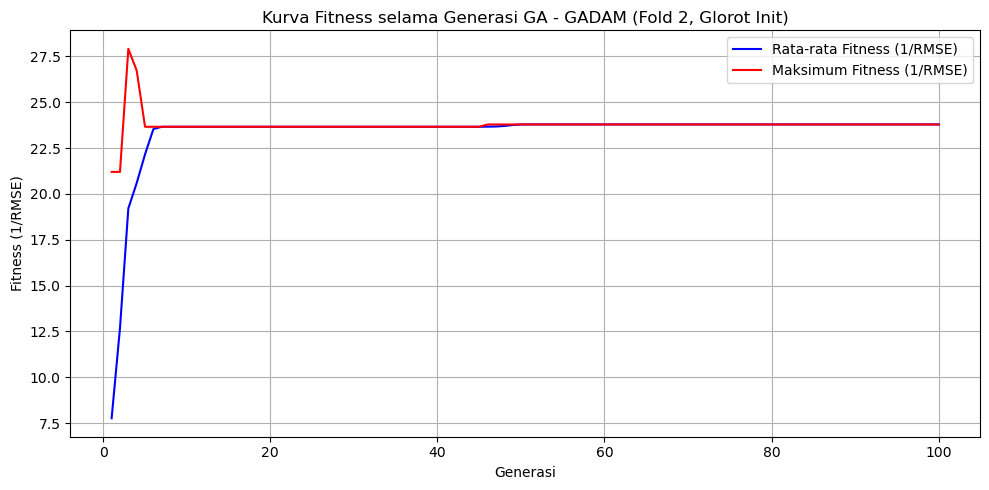

Fold 2 - GADAM - Epoch 1: Loss Latih = 0.001253, Loss Validasi = 0.000548
Fold 2 - GADAM - Epoch 2: Loss Latih = 0.001285, Loss Validasi = 0.000549
Fold 2 - GADAM - Epoch 3: Loss Latih = 0.001211, Loss Validasi = 0.000545
Fold 2 - GADAM - Epoch 4: Loss Latih = 0.001215, Loss Validasi = 0.000544
Fold 2 - GADAM - Epoch 5: Loss Latih = 0.001192, Loss Validasi = 0.000543
Fold 2 - GADAM - Epoch 6: Loss Latih = 0.001193, Loss Validasi = 0.000542
Fold 2 - GADAM - Epoch 7: Loss Latih = 0.001181, Loss Validasi = 0.000541
Fold 2 - GADAM - Epoch 8: Loss Latih = 0.001178, Loss Validasi = 0.000540
Fold 2 - GADAM - Epoch 9: Loss Latih = 0.001170, Loss Validasi = 0.000539
Fold 2 - GADAM - Epoch 10: Loss Latih = 0.001166, Loss Validasi = 0.000539
Fold 2 - GADAM - Epoch 11: Loss Latih = 0.001160, Loss Validasi = 0.000539
Fold 2 - GADAM - Epoch 12: Loss Latih = 0.001155, Loss Validasi = 0.000538
Fold 2 - GADAM - Epoch 13: Loss Latih = 0.001151, Loss Validasi = 0.000537
Fold 2 - GADAM - Epoch 14: Loss La

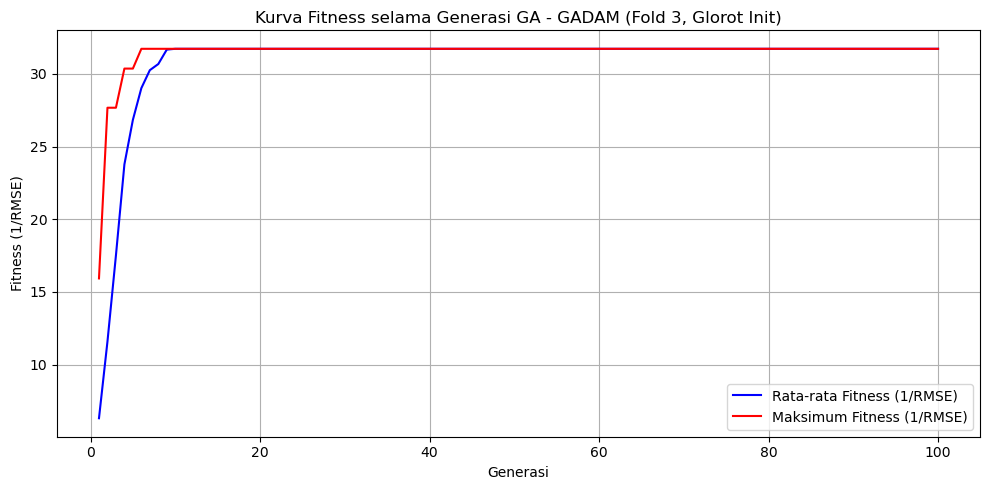

Fold 3 - GADAM - Epoch 1: Loss Latih = 0.001000, Loss Validasi = 0.001407
Fold 3 - GADAM - Epoch 2: Loss Latih = 0.000992, Loss Validasi = 0.001404
Fold 3 - GADAM - Epoch 3: Loss Latih = 0.000983, Loss Validasi = 0.001407
Fold 3 - GADAM - Epoch 4: Loss Latih = 0.000975, Loss Validasi = 0.001401
Fold 3 - GADAM - Epoch 5: Loss Latih = 0.000972, Loss Validasi = 0.001401
Fold 3 - GADAM - Epoch 6: Loss Latih = 0.000971, Loss Validasi = 0.001403
Fold 3 - GADAM - Epoch 7: Loss Latih = 0.000969, Loss Validasi = 0.001405
Fold 3 - GADAM - Epoch 8: Loss Latih = 0.000967, Loss Validasi = 0.001405
Fold 3 - GADAM - Epoch 9: Loss Latih = 0.000965, Loss Validasi = 0.001406
Fold 3 - GADAM - Epoch 10: Loss Latih = 0.000964, Loss Validasi = 0.001407
Epoch 10: early stopping

=== Melatih GADAM Fold 4 ===
Generasi 1: Rata-rata Fitness (1/RMSE) = 3.957624, Maksimum Fitness (1/RMSE) = 9.819307
Generasi 2: Rata-rata Fitness (1/RMSE) = 6.017631, Maksimum Fitness (1/RMSE) = 9.794607
Generasi 3: Rata-rata Fitnes

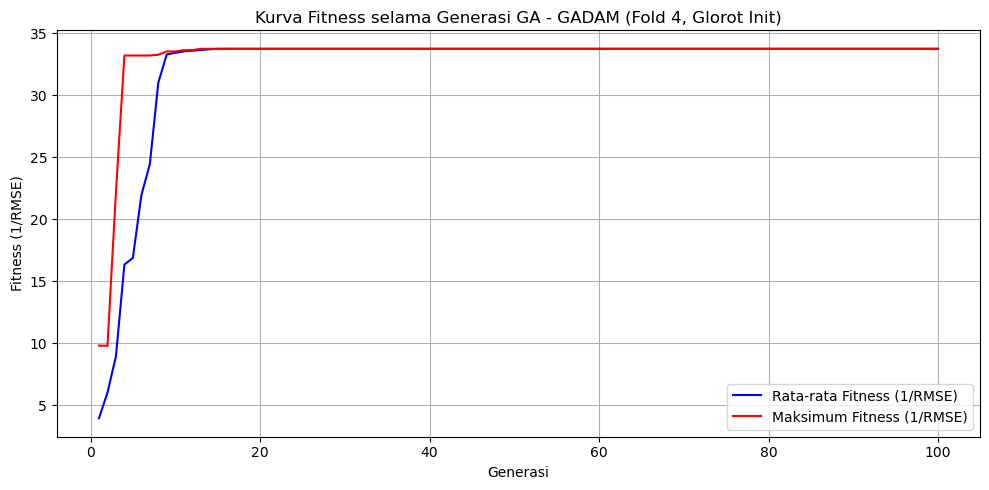

Fold 4 - GADAM - Epoch 1: Loss Latih = 0.000902, Loss Validasi = 0.002141
Fold 4 - GADAM - Epoch 2: Loss Latih = 0.000888, Loss Validasi = 0.002150
Fold 4 - GADAM - Epoch 3: Loss Latih = 0.000882, Loss Validasi = 0.002154
Fold 4 - GADAM - Epoch 4: Loss Latih = 0.000881, Loss Validasi = 0.002158
Fold 4 - GADAM - Epoch 5: Loss Latih = 0.000880, Loss Validasi = 0.002166
Fold 4 - GADAM - Epoch 6: Loss Latih = 0.000881, Loss Validasi = 0.002165
Epoch 6: early stopping


In [7]:
# Inisialisasi untuk menyimpan hasil
gadam_metrics = []
gadam_predictions_per_fold = []
gadam_best_weights = []
gadam_history = []

# Setup GA untuk GADAM
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", glorot_init, INPUT_DIM, HIDDEN_NEURONS)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=MUTATION_SIGMA, indpb=MUTATION_PROB)
# toolbox.register("select", tools.selRoulette)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Callback untuk logging
class EpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, fold):
        super().__init__()
        self.fold = fold

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        print(f"Fold {self.fold} - GADAM - Epoch {epoch + 1}: Loss Latih = {train_loss:.6f}, Loss Validasi = {val_loss:.6f}")

# Buat direktori untuk menyimpan model jika belum ada
os.makedirs('models', exist_ok=True)

# Loop untuk setiap fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n=== Melatih GADAM Fold {fold} ===")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_close = close_values[train_idx]
    test_close = close_values[test_idx]
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]

    # Buat model untuk GA
    ga_model = build_ann_model(INPUT_DIM, HIDDEN_NEURONS, use_dropout=False, use_l2=False)

    # Register fungsi evaluasi
    toolbox.register("evaluate", evaluate_individual, model=ga_model, X=X_train, y=y_train)

    # Jalankan GA
    population = toolbox.population(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    hof = tools.HallOfFame(1)

    # List untuk menyimpan fitness per generasi
    fitness_avg_history = []
    fitness_max_history = []

    for gen in range(GENERATIONS):
        population = algorithms.varAnd(population, toolbox, cxpb=CROSSOVER_PROB, mutpb=MUTATION_PROB)
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        hof.update(population)
        population = toolbox.select(population, len(population))
        record = stats.compile(population)
        fitness_avg_history.append(record['avg'])
        fitness_max_history.append(record['max'])
        print(f"Generasi {gen + 1}: Rata-rata Fitness (1/RMSE) = {record['avg']:.6f}, Maksimum Fitness (1/RMSE) = {record['max']:.6f}")

    # Visualisasi kurva fitness
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, GENERATIONS + 1), fitness_avg_history, label='Rata-rata Fitness (1/RMSE)', color='blue')
    plt.plot(range(1, GENERATIONS + 1), fitness_max_history, label='Maksimum Fitness (1/RMSE)', color='red')
    plt.title(f'Kurva Fitness selama Generasi GA - GADAM (Fold {fold}, Glorot Init)')
    plt.xlabel('Generasi')
    plt.ylabel('Fitness (1/RMSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'ihsg_fitness_curve_gadam_fold_{fold}_glorot.png')
    plt.show()

    best_weights = hof[0]
    gadam_best_weights.append(best_weights)

    # Buat model GADAM dan set bobot awal
    gadam_model = build_ann_model(INPUT_DIM, HIDDEN_NEURONS, use_dropout=False, use_l2=False)
    set_model_weights(gadam_model, best_weights)

    # Latih dengan ADAM
    history = gadam_model.fit(X_train, y_train,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_test, y_test),
                              verbose=0,
                              callbacks=[EpochLogger(fold),
                                         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1),
                                         LearningRateScheduler(lr_scheduler)])
    gadam_history.append(history.history)

    # Prediksi
    gadam_predictions = gadam_model.predict(np.concatenate([X_train, X_test]), verbose=0).flatten()
    gadam_predictions_denorm = denormalize(gadam_predictions, close_min, close_max)

    # Simpan model
    gadam_model.save(f'models/gadam_fold_{fold}.keras')

    # Simpan prediksi
    fold_pred_df = pd.DataFrame({
        'Fold': fold,
        'Date': np.concatenate([train_dates, test_dates]),
        'Actual_Close': np.concatenate([train_close, test_close]),
        'Predicted_GADAM': gadam_predictions_denorm,
        'Data': ['Latih'] * len(train_dates) + ['Uji'] * len(test_dates)
    })
    gadam_predictions_per_fold.append(fold_pred_df)

    # Bersihkan memori
    import gc
    gc.collect()
    tf.keras.backend.clear_session()

## 8. Validasi GADAM per Fold
Mengevaluasi performa GADAM pada setiap fold dan membuat visualisasi.


=== Validasi GADAM Fold 1 ===


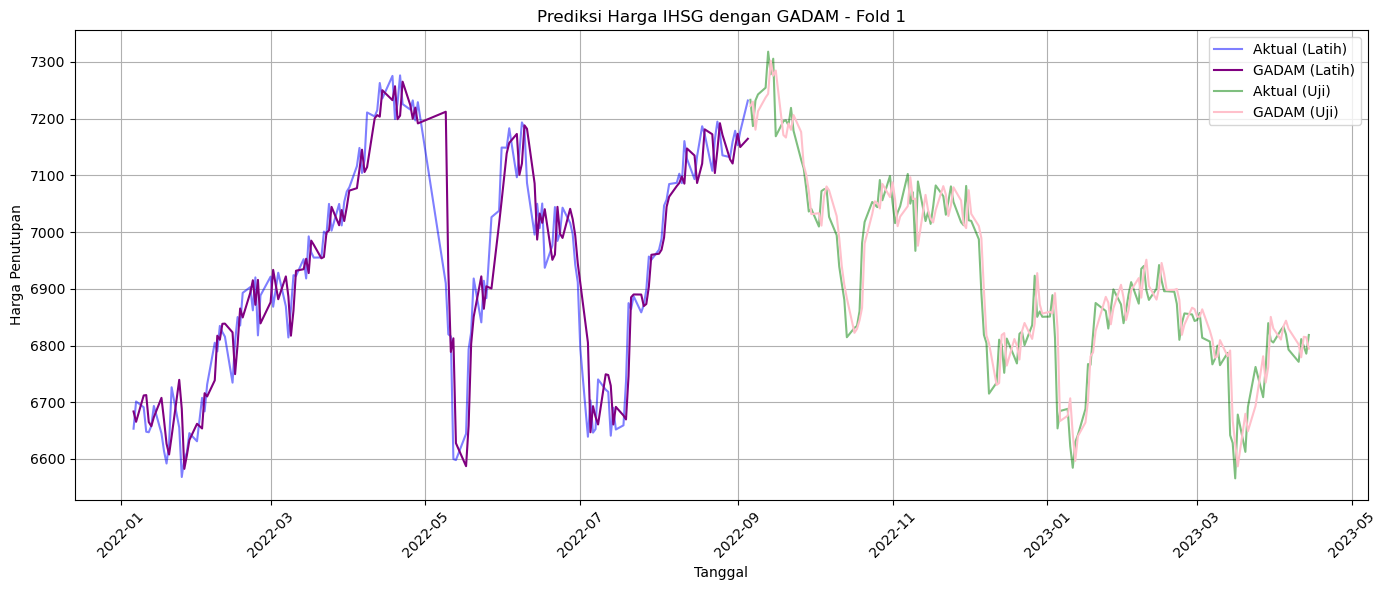

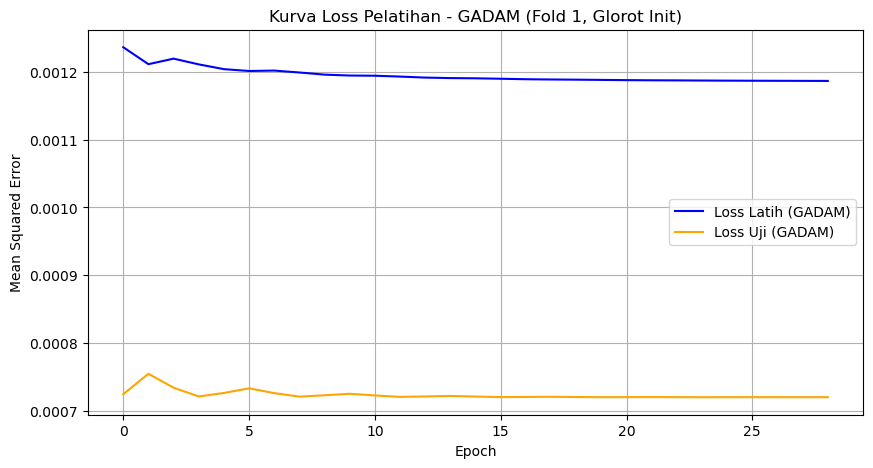


=== Validasi GADAM Fold 2 ===


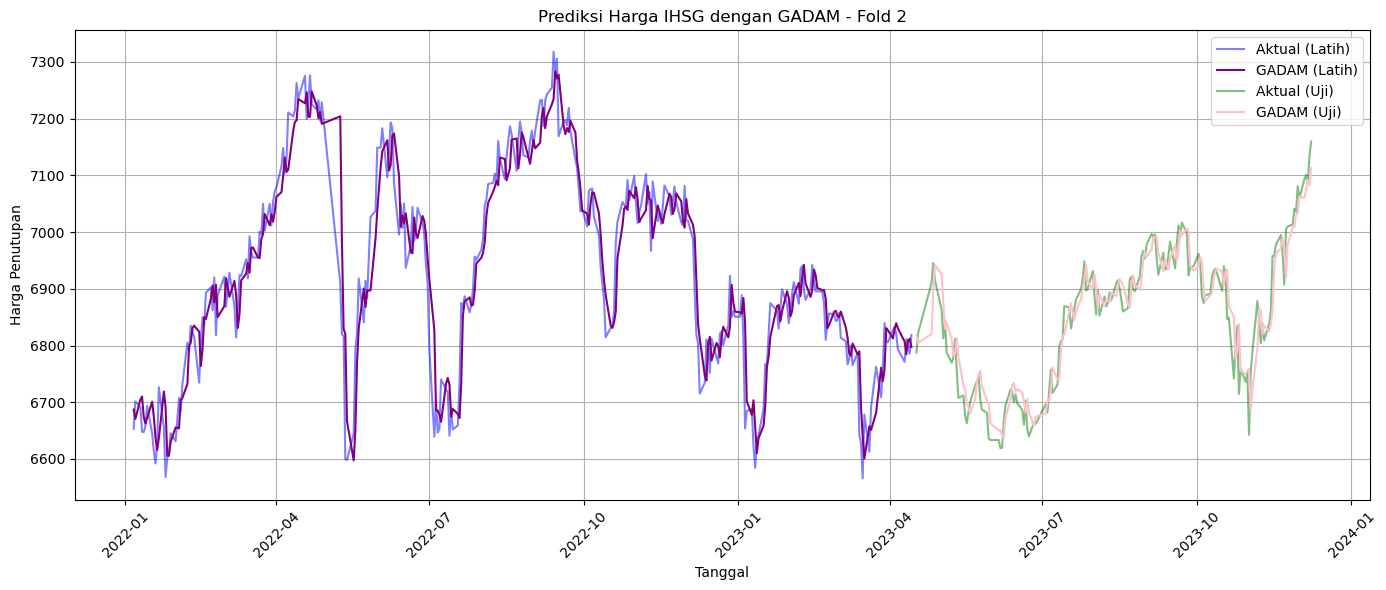

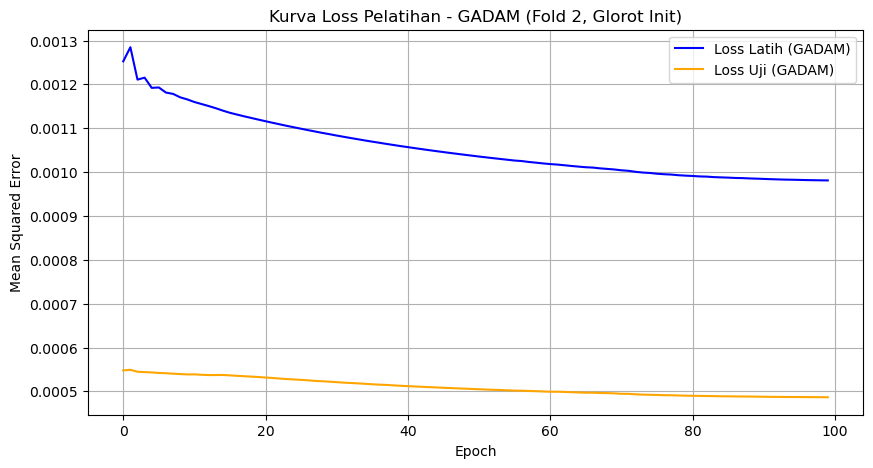


=== Validasi GADAM Fold 3 ===


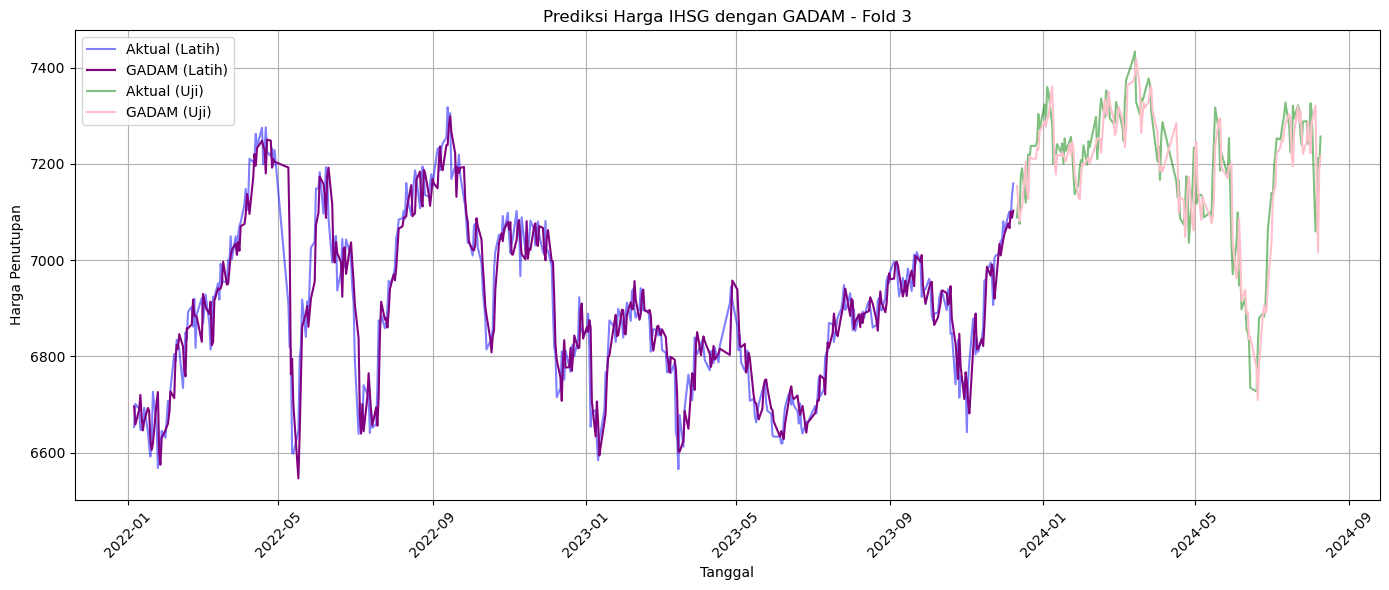

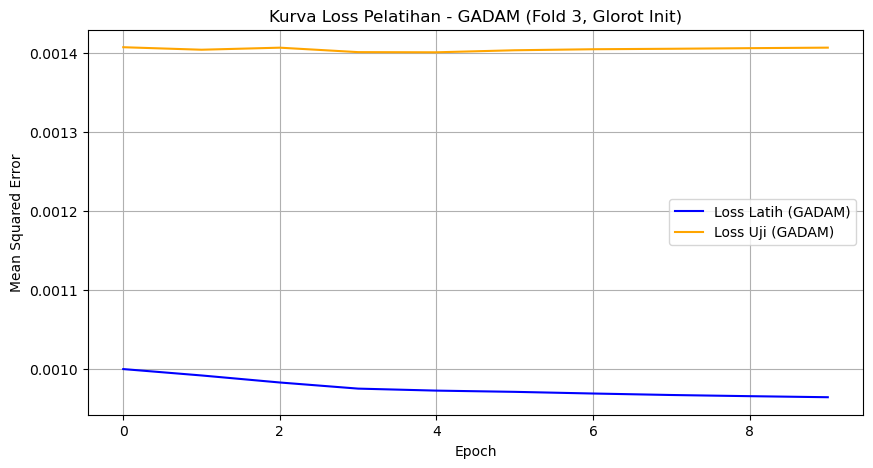


=== Validasi GADAM Fold 4 ===


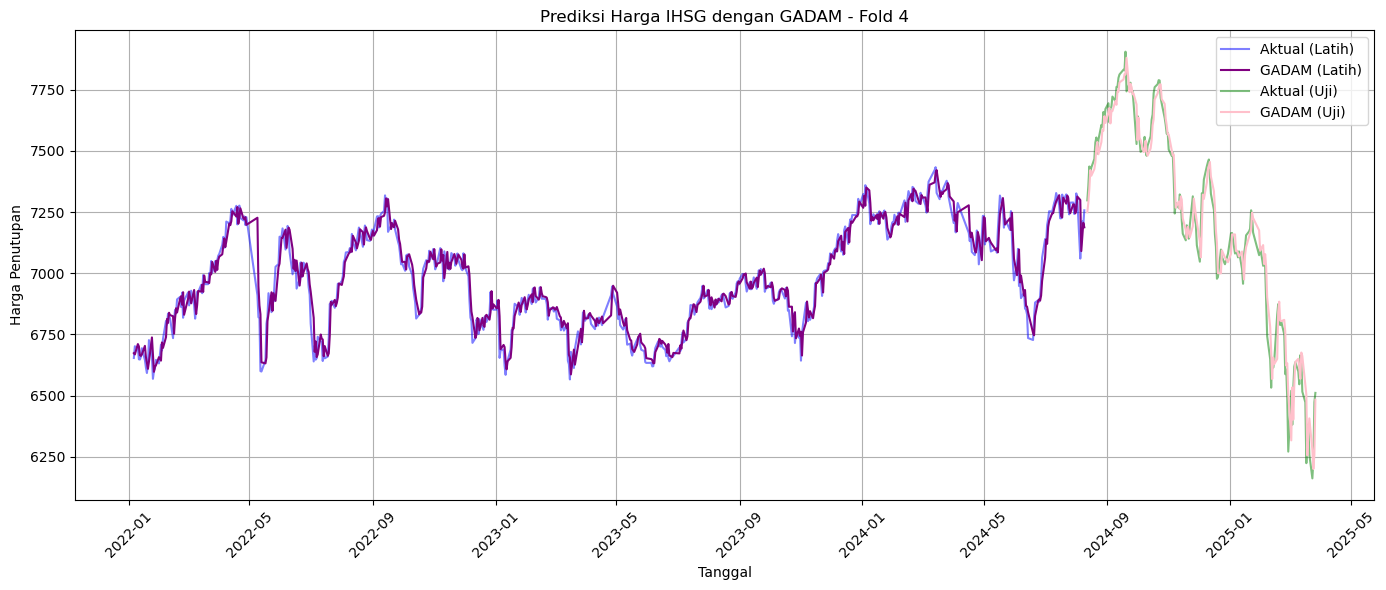

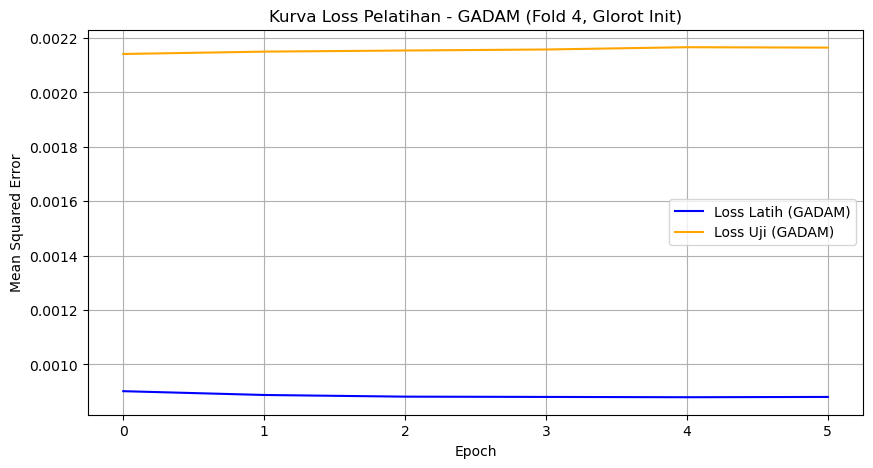

In [8]:
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n=== Validasi GADAM Fold {fold} ===")
    train_close = close_values[train_idx]
    test_close = close_values[test_idx]
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]

    # Ambil prediksi
    fold_pred_df = gadam_predictions_per_fold[fold-1]
    gadam_pred = fold_pred_df['Predicted_GADAM'].values
    train_pred = gadam_pred[:len(train_close)]
    test_pred = gadam_pred[len(train_close):]

    # Hitung metrik
    rmse_train, mae_train, mape_train = calculate_metrics(train_close, train_pred)
    rmse_test, mae_test, mape_test = calculate_metrics(test_close, test_pred)
    gadam_metrics.append({'Fold': fold, 'Data': 'Latih', 'RMSE': rmse_train, 'MAE': mae_train, 'MAPE': mape_train})
    gadam_metrics.append({'Fold': fold, 'Data': 'Uji', 'RMSE': rmse_test, 'MAE': mae_test, 'MAPE': mape_test})

    # Visualisasi prediksi vs aktual
    plt.figure(figsize=(14, 6))
    plt.plot(train_dates, train_close, label='Aktual (Latih)', color='blue', alpha=0.5)
    plt.plot(train_dates, train_pred, label='GADAM (Latih)', color='purple')
    plt.plot(test_dates, test_close, label='Aktual (Uji)', color='green', alpha=0.5)
    plt.plot(test_dates, test_pred, label='GADAM (Uji)', color='pink')
    plt.title(f'Prediksi Harga IHSG dengan GADAM - Fold {fold}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'ihsg_prediction_gadam_fold_{fold}_glorot.png')
    plt.show()

    # Visualisasi kurva loss
    history = gadam_history[fold-1]
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Loss Latih (GADAM)', color='blue')
    plt.plot(history['val_loss'], label='Loss Uji (GADAM)', color='orange')
    plt.title(f'Kurva Loss Pelatihan - GADAM (Fold {fold}, Glorot Init)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'ihsg_loss_curve_gadam_fold_{fold}_glorot.png')
    plt.show()

## 9. Pelatihan ADAM per Fold
Melatih model ANN langsung dengan ADAM tanpa optimasi GA.

In [9]:
# Inisialisasi untuk menyimpan hasil
adam_metrics = []
adam_predictions_per_fold = []
adam_history = []

# Callback untuk logging
class EpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, fold):
        super().__init__()
        self.fold = fold

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        print(f"Fold {self.fold} - ADAM - Epoch {epoch + 1}: Loss Latih = {train_loss:.6f}, Loss Validasi = {val_loss:.6f}")

# Loop untuk setiap fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n=== Melatih ADAM Fold {fold} ===")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_close = close_values[train_idx]
    test_close = close_values[test_idx]
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]

    # Buat model ADAM
    adam_model = build_ann_model(INPUT_DIM, HIDDEN_NEURONS, use_dropout=True, use_l2=True)

    # Latih dengan ADAM
    history = adam_model.fit(X_train, y_train,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_data=(X_test, y_test),
                             verbose=0,
                             callbacks=[EpochLogger(fold),
                                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1),
                                        LearningRateScheduler(lr_scheduler)])
    adam_history.append(history.history)

    # Prediksi
    adam_predictions = adam_model.predict(np.concatenate([X_train, X_test]), verbose=0).flatten()
    adam_predictions_denorm = denormalize(adam_predictions, close_min, close_max)

    # Simpan model
    adam_model.save(f'models/adam_fold_{fold}.keras')

    # Simpan prediksi
    fold_pred_df = pd.DataFrame({
        'Fold': fold,
        'Date': np.concatenate([train_dates, test_dates]),
        'Actual_Close': np.concatenate([train_close, test_close]),
        'Predicted_ADAM': adam_predictions_denorm,
        'Data': ['Latih'] * len(train_dates) + ['Uji'] * len(test_dates)
    })
    adam_predictions_per_fold.append(fold_pred_df)

    # Bersihkan memori
    import gc
    gc.collect()
    tf.keras.backend.clear_session()


=== Melatih ADAM Fold 1 ===
Fold 1 - ADAM - Epoch 1: Loss Latih = 0.109815, Loss Validasi = 0.030434
Fold 1 - ADAM - Epoch 2: Loss Latih = 0.090231, Loss Validasi = 0.029993
Fold 1 - ADAM - Epoch 3: Loss Latih = 0.087135, Loss Validasi = 0.029957
Fold 1 - ADAM - Epoch 4: Loss Latih = 0.087959, Loss Validasi = 0.030013
Fold 1 - ADAM - Epoch 5: Loss Latih = 0.092266, Loss Validasi = 0.030207
Fold 1 - ADAM - Epoch 6: Loss Latih = 0.083243, Loss Validasi = 0.030293
Fold 1 - ADAM - Epoch 7: Loss Latih = 0.090692, Loss Validasi = 0.030085
Fold 1 - ADAM - Epoch 8: Loss Latih = 0.080867, Loss Validasi = 0.029586
Fold 1 - ADAM - Epoch 9: Loss Latih = 0.066863, Loss Validasi = 0.029241
Fold 1 - ADAM - Epoch 10: Loss Latih = 0.078416, Loss Validasi = 0.029330
Fold 1 - ADAM - Epoch 11: Loss Latih = 0.075803, Loss Validasi = 0.029254
Fold 1 - ADAM - Epoch 12: Loss Latih = 0.079865, Loss Validasi = 0.028792
Fold 1 - ADAM - Epoch 13: Loss Latih = 0.063291, Loss Validasi = 0.028080
Fold 1 - ADAM - Ep

## 10. Validasi ADAM per Fold
Mengevaluasi performa ADAM pada setiap fold dan membuat visualisasi.


=== Validasi ADAM Fold 1 ===


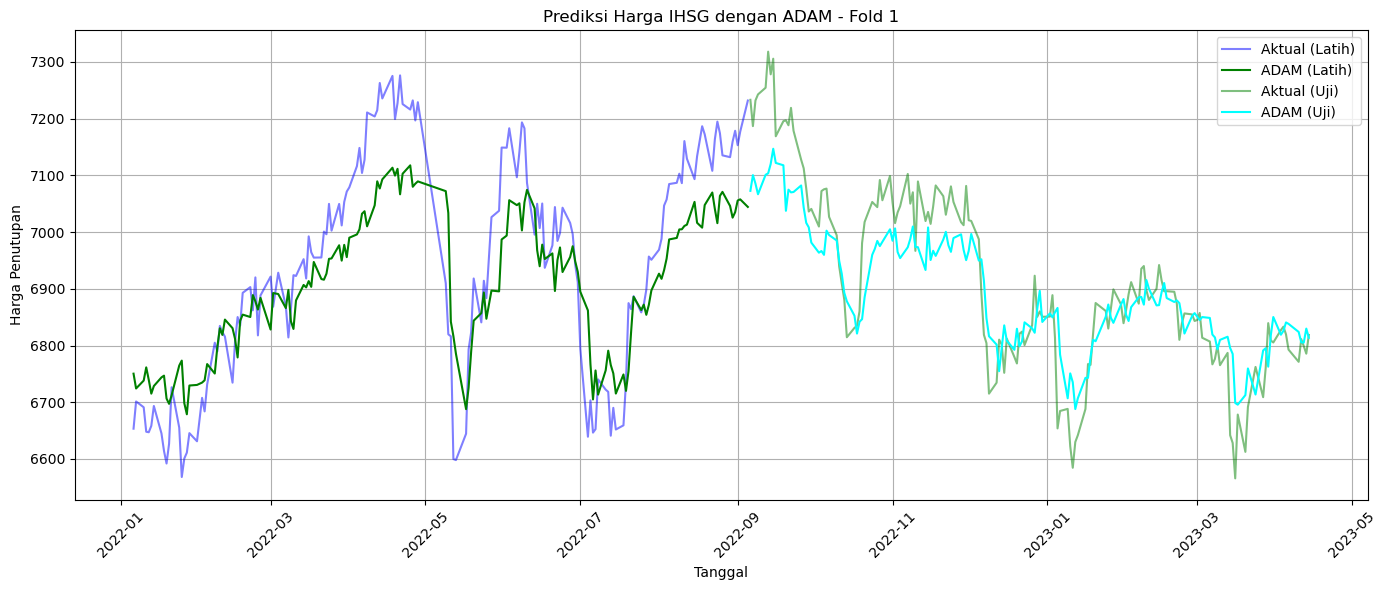

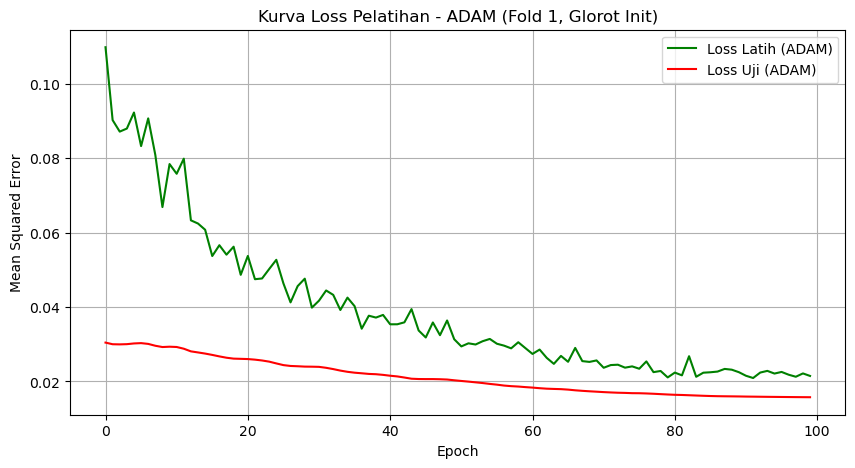


=== Validasi ADAM Fold 2 ===


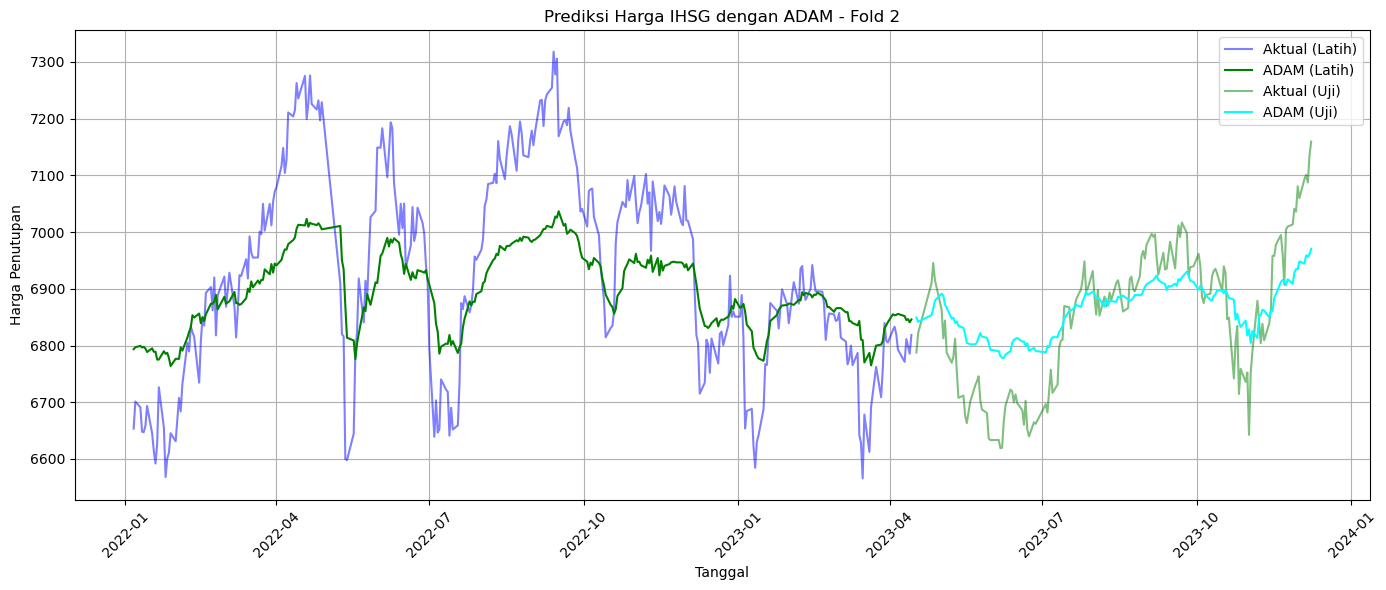

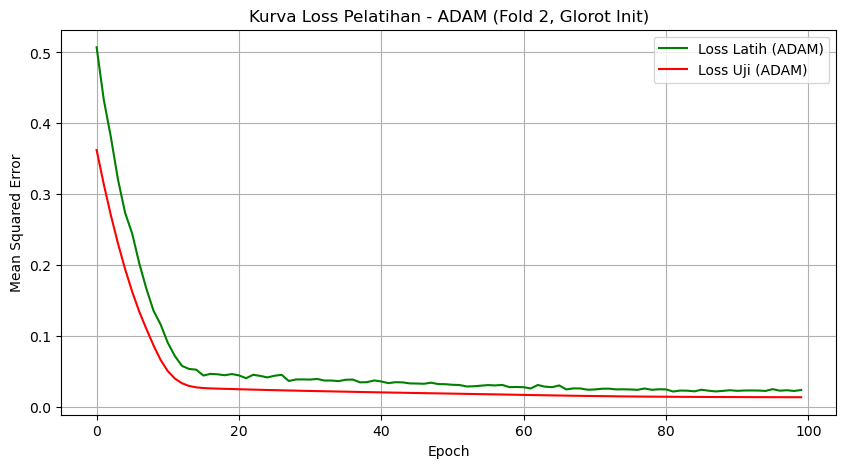


=== Validasi ADAM Fold 3 ===


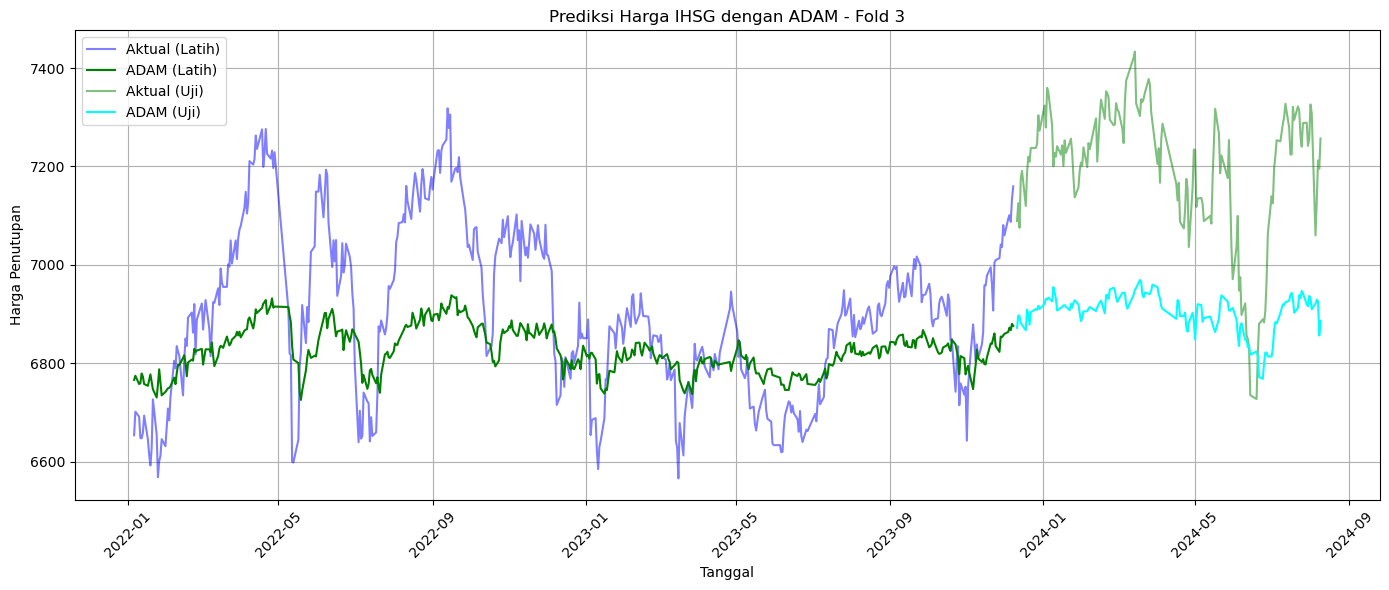

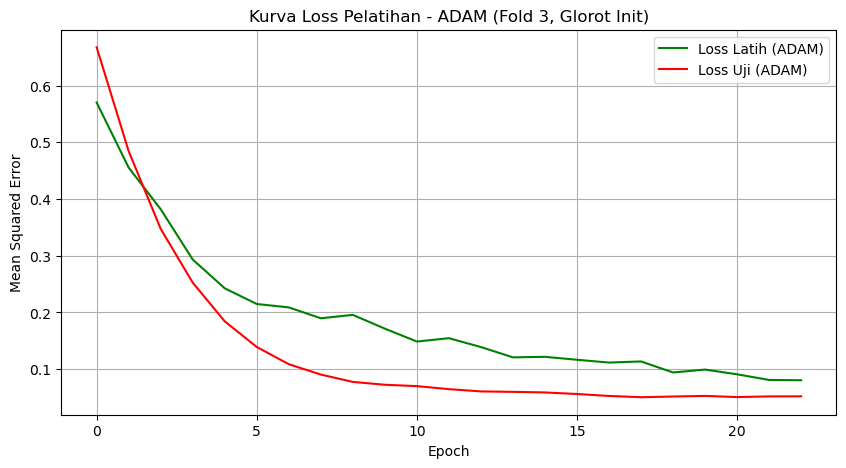


=== Validasi ADAM Fold 4 ===


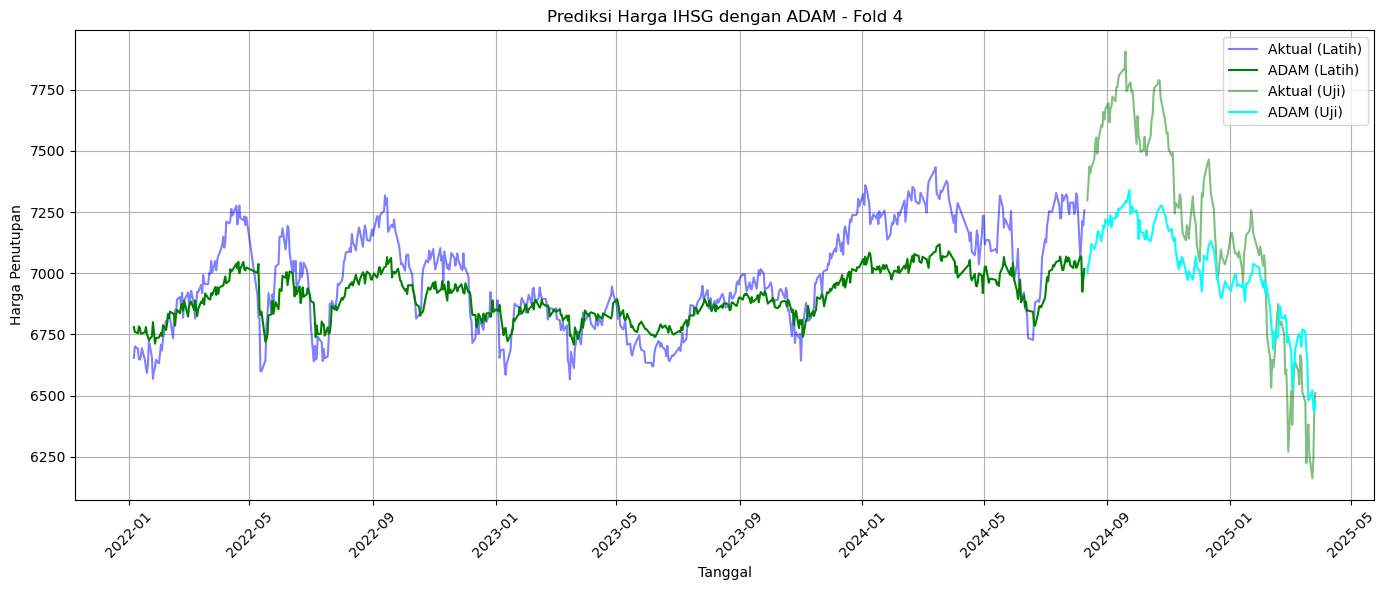

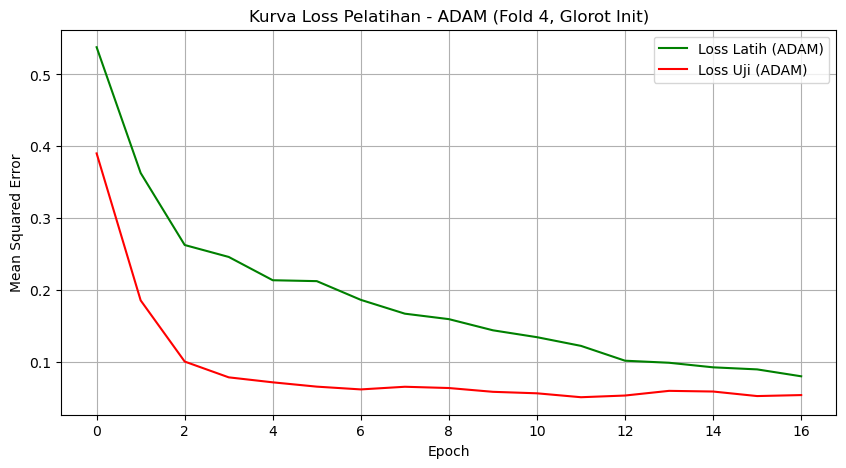

In [10]:
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n=== Validasi ADAM Fold {fold} ===")
    train_close = close_values[train_idx]
    test_close = close_values[test_idx]
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]

    # Ambil prediksi
    fold_pred_df = adam_predictions_per_fold[fold-1]
    adam_pred = fold_pred_df['Predicted_ADAM'].values
    train_pred = adam_pred[:len(train_close)]
    test_pred = adam_pred[len(train_close):]

    # Hitung metrik
    rmse_train, mae_train, mape_train = calculate_metrics(train_close, train_pred)
    rmse_test, mae_test, mape_test = calculate_metrics(test_close, test_pred)
    adam_metrics.append({'Fold': fold, 'Data': 'Latih', 'RMSE': rmse_train, 'MAE': mae_train, 'MAPE': mape_train})
    adam_metrics.append({'Fold': fold, 'Data': 'Uji', 'RMSE': rmse_test, 'MAE': mae_test, 'MAPE': mape_test})

    # Visualisasi prediksi vs aktual
    plt.figure(figsize=(14, 6))
    plt.plot(train_dates, train_close, label='Aktual (Latih)', color='blue', alpha=0.5)
    plt.plot(train_dates, train_pred, label='ADAM (Latih)', color='green')
    plt.plot(test_dates, test_close, label='Aktual (Uji)', color='green', alpha=0.5)
    plt.plot(test_dates, test_pred, label='ADAM (Uji)', color='cyan')
    plt.title(f'Prediksi Harga IHSG dengan ADAM - Fold {fold}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'ihsg_prediction_adam_fold_{fold}_glorot.png')
    plt.show()

    # Visualisasi kurva loss
    history = adam_history[fold-1]
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Loss Latih (ADAM)', color='green')
    plt.plot(history['val_loss'], label='Loss Uji (ADAM)', color='red')
    plt.title(f'Kurva Loss Pelatihan - ADAM (Fold {fold}, Glorot Init)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'ihsg_loss_curve_adam_fold_{fold}_glorot.png')
    plt.show()

## 11. Agregasi dan Simpan Hasil
Mengagregasi metrik, menyimpan hasil, dan membuat visualisasi kesalahan prediksi.

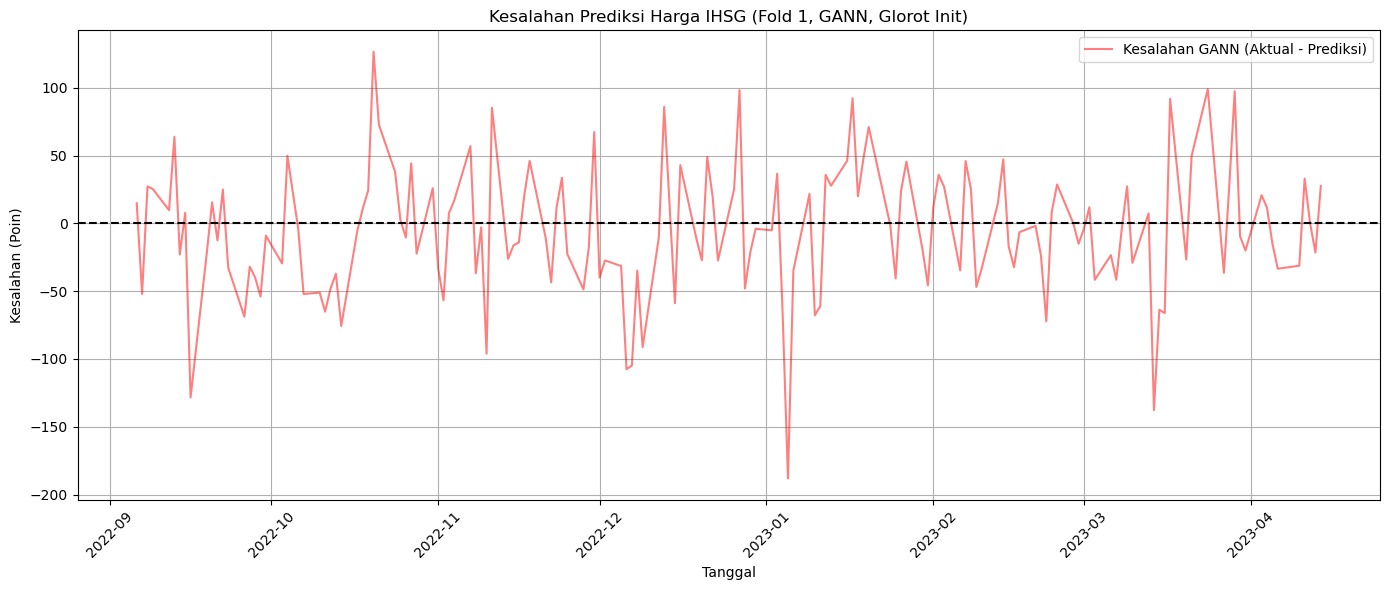

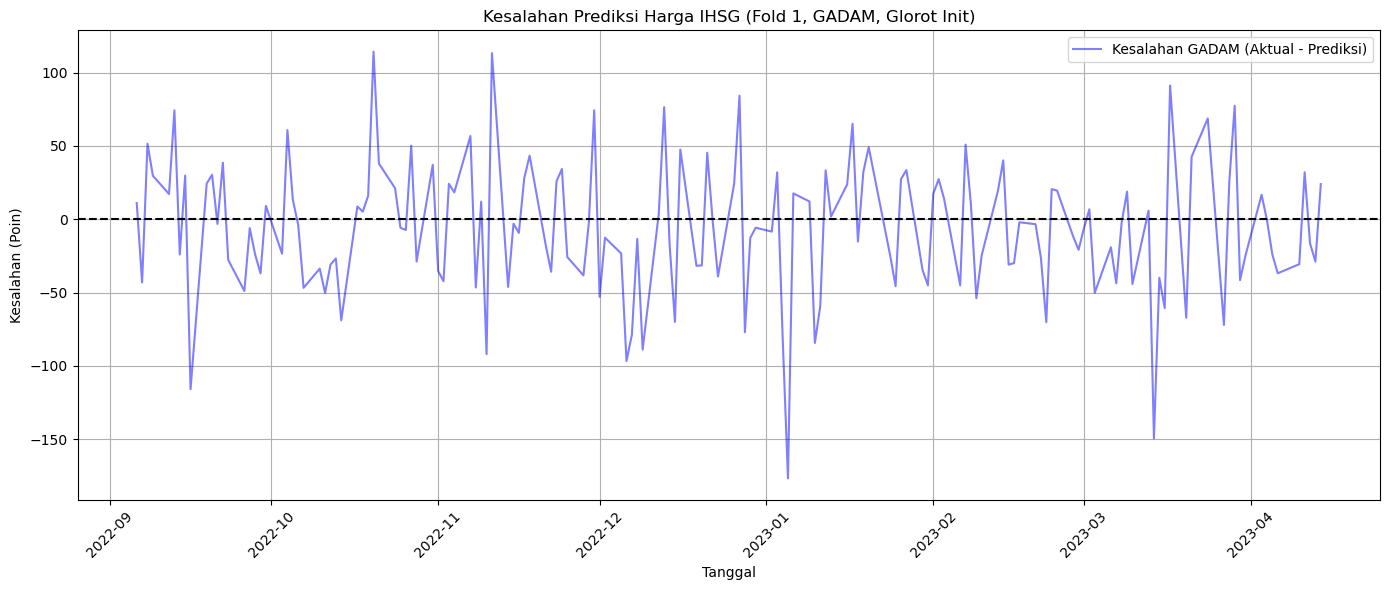

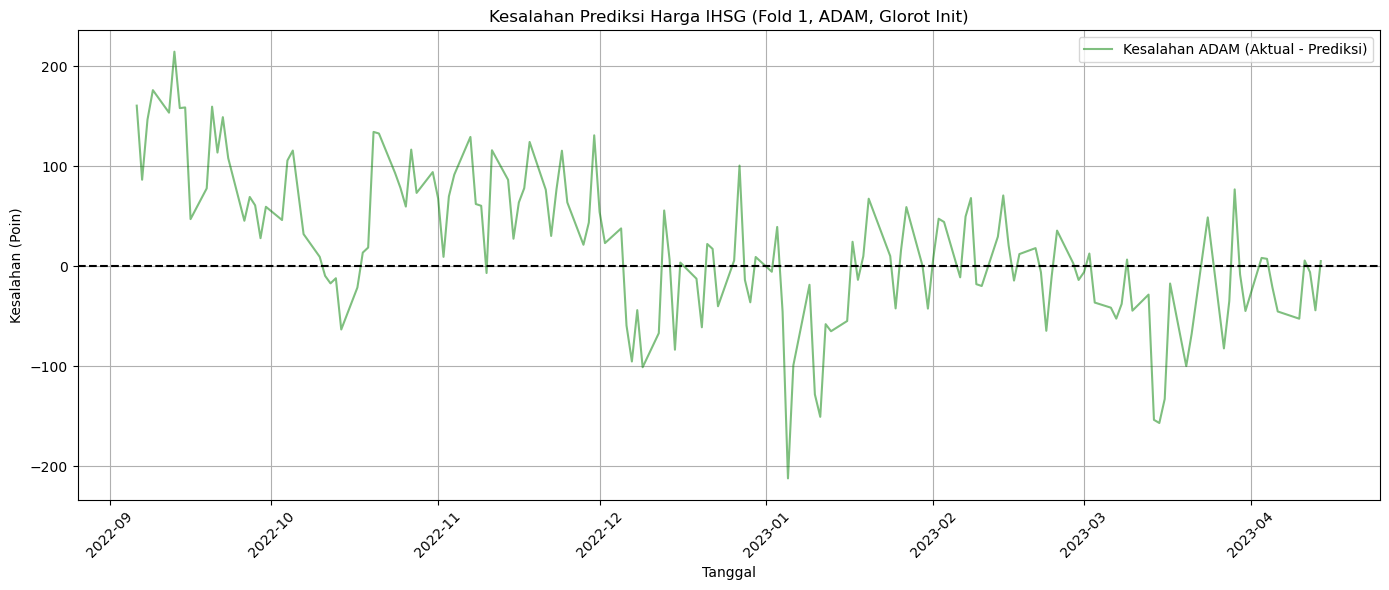

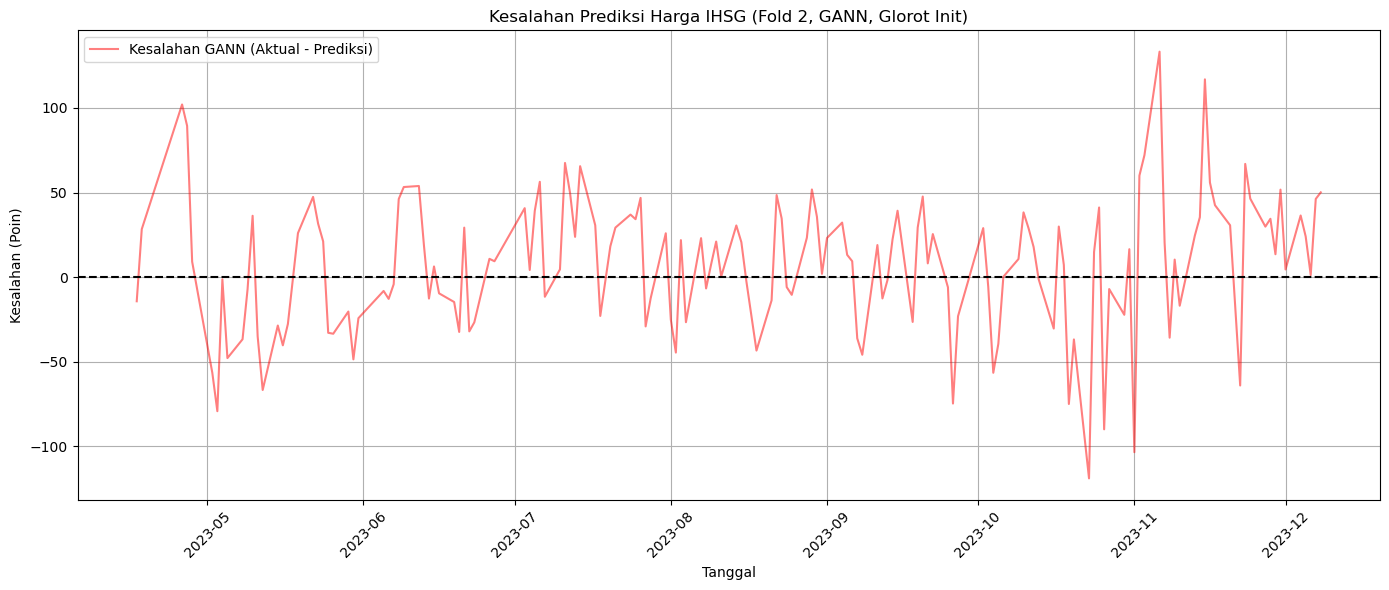

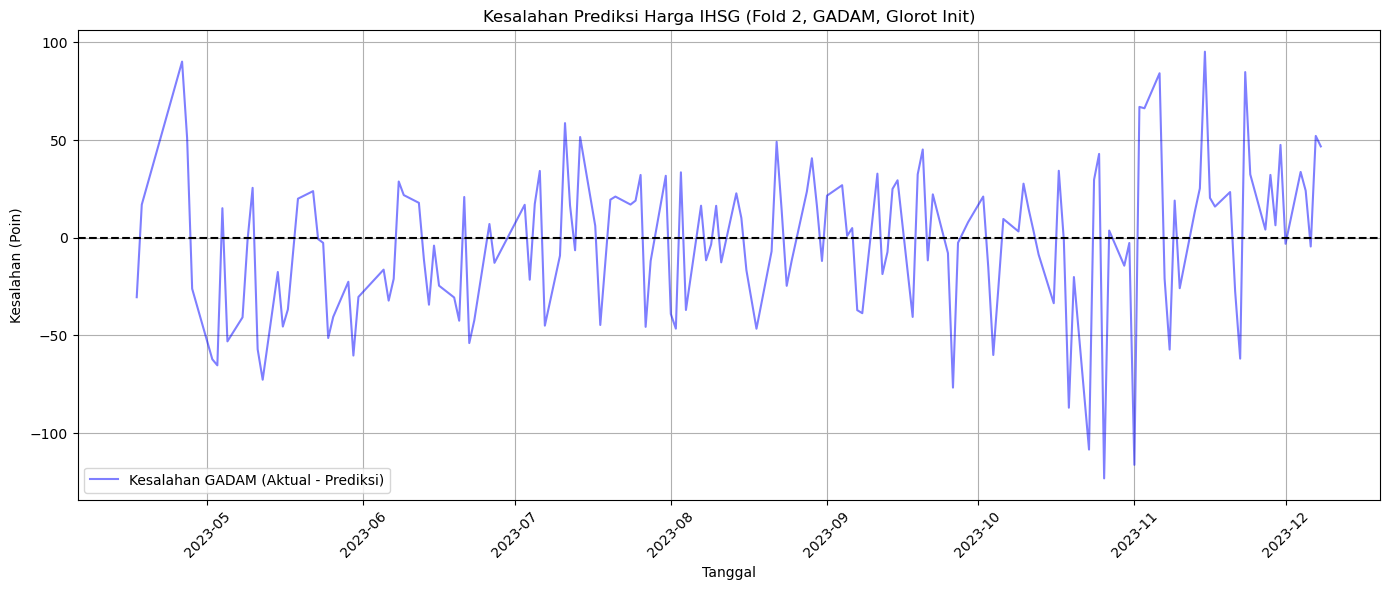

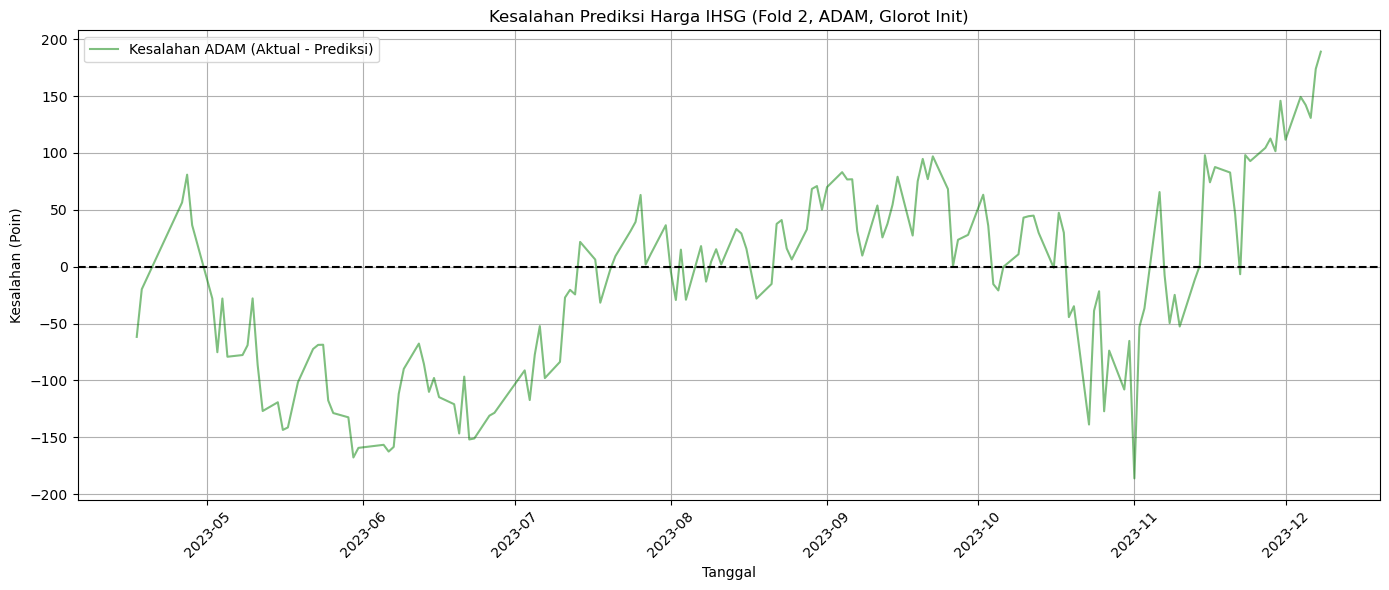

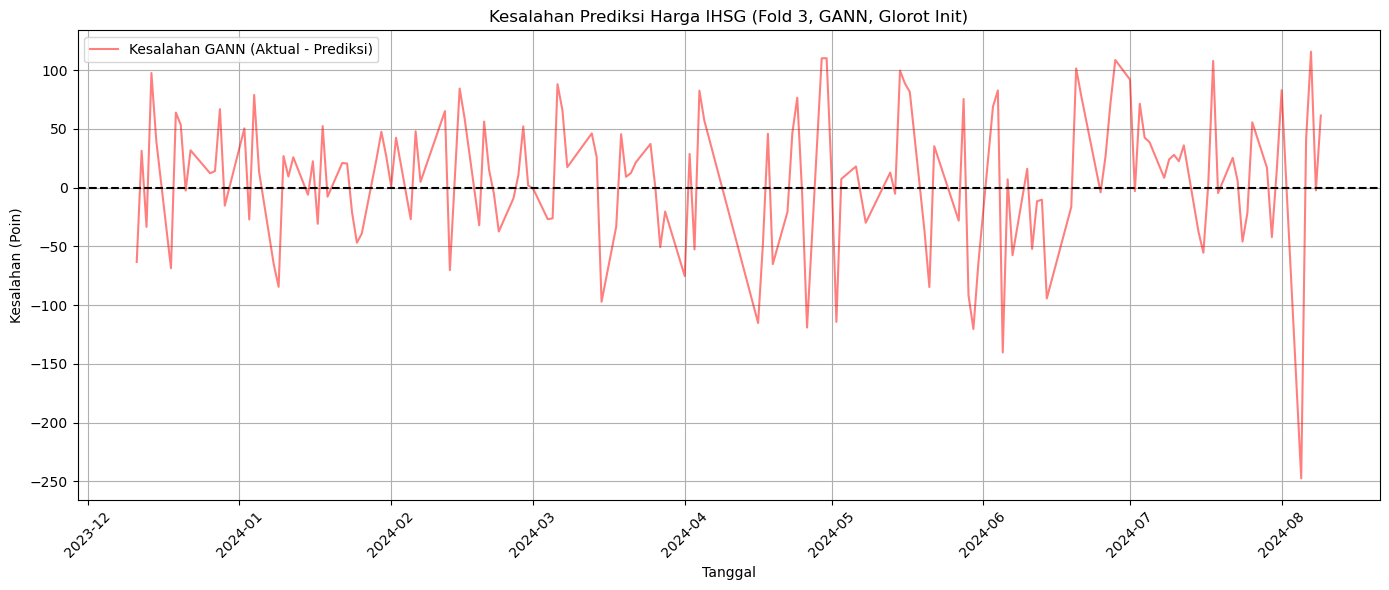

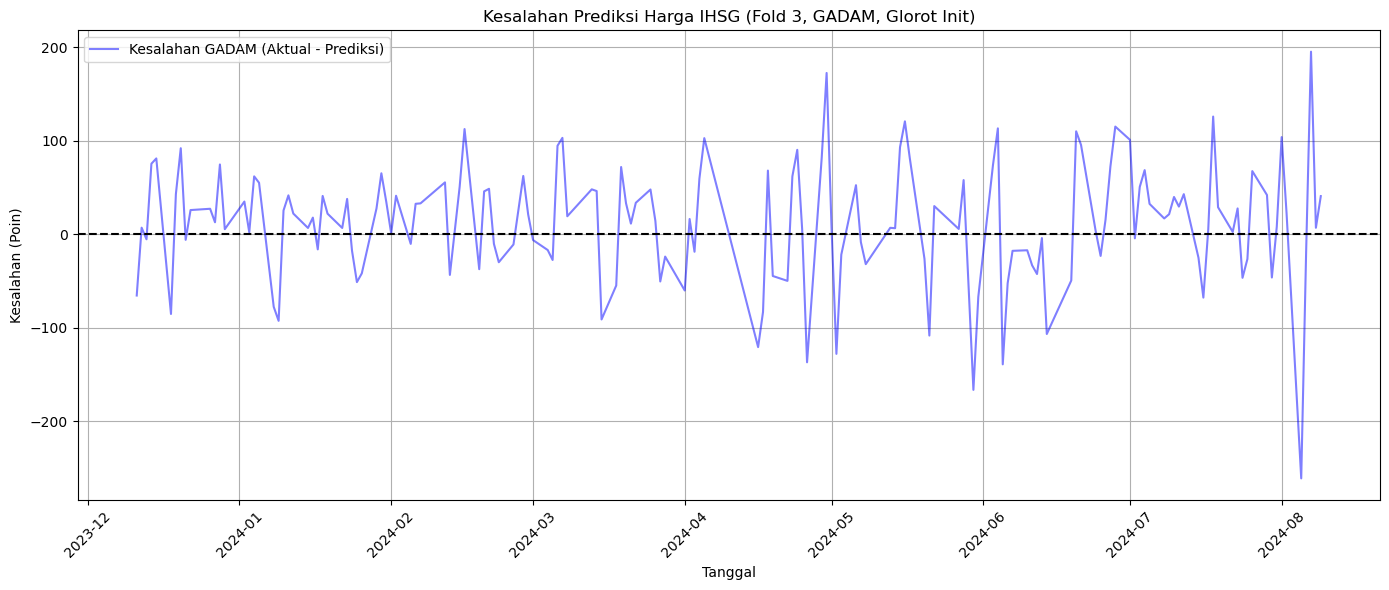

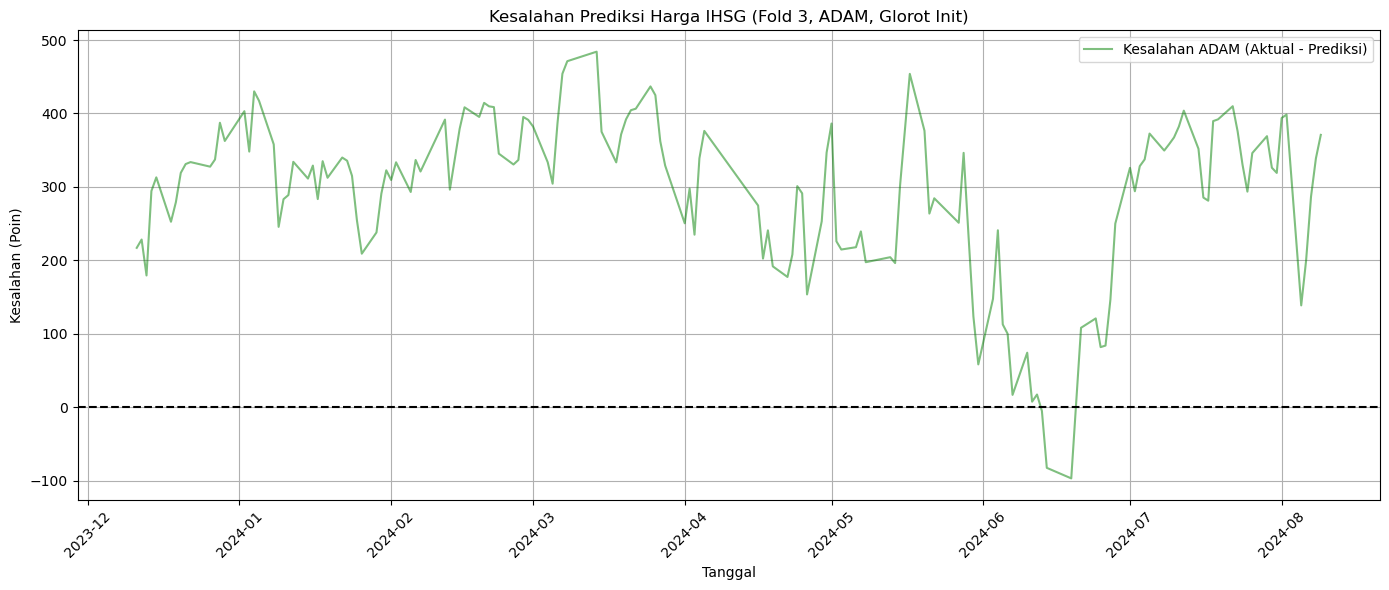

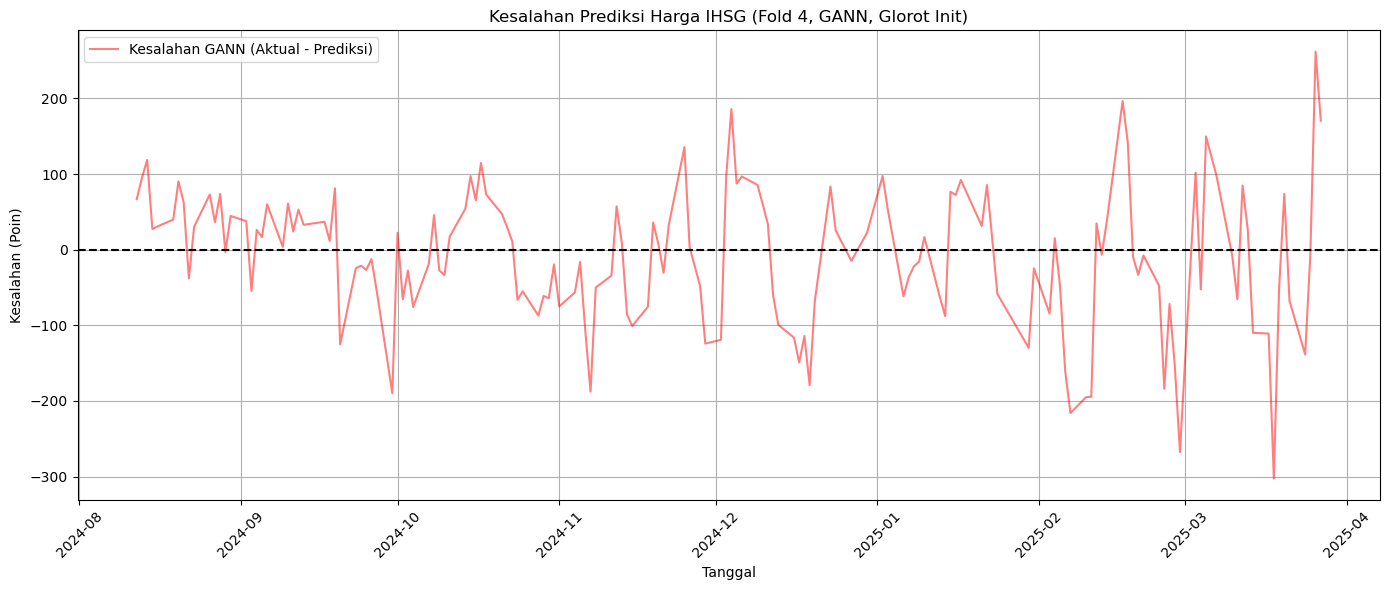

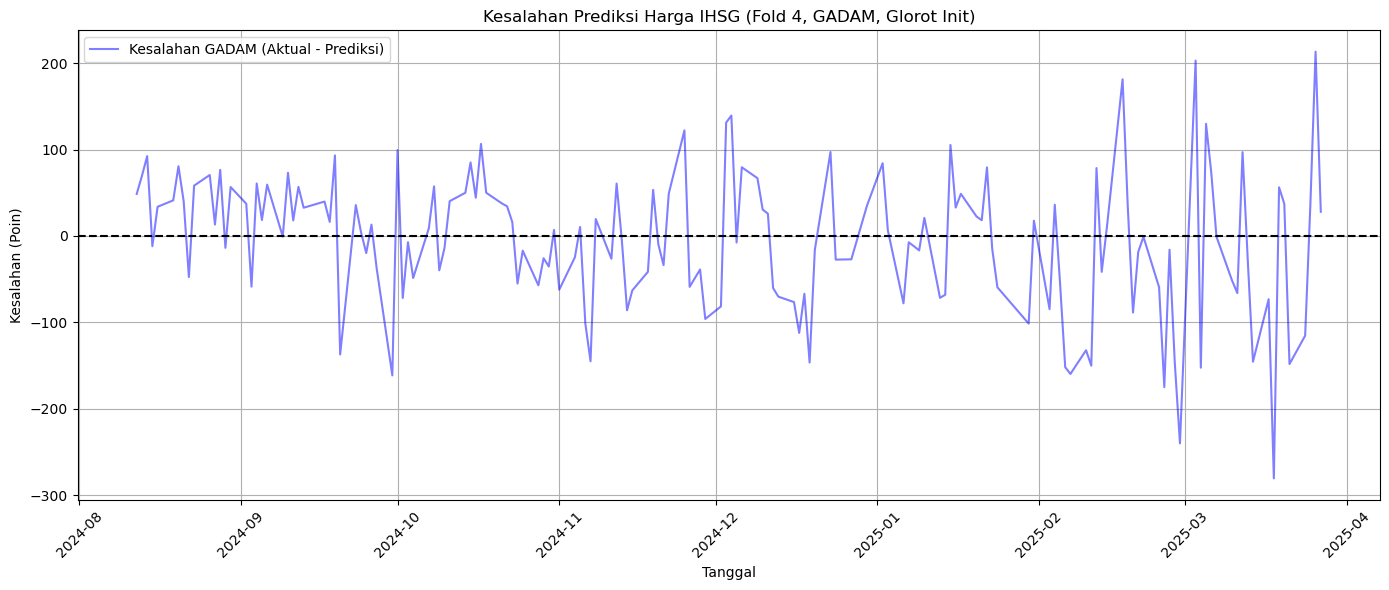

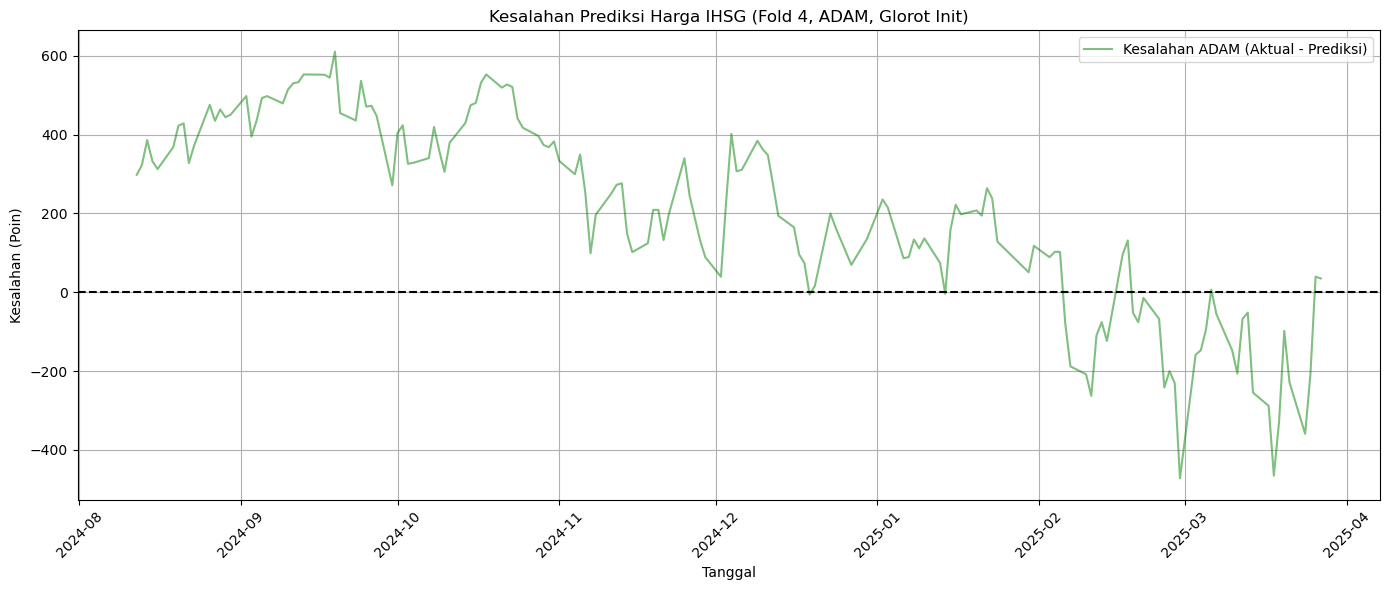


Perbandingan Metrik Evaluasi (Rata-rata):
   Model   Data    RMSE     MAE  MAPE
0   GANN  Latih   57.46   42.19  0.61
1   GANN    Uji   59.60   46.72  0.67
2  GADAM  Latih   54.94   41.27  0.60
3  GADAM    Uji   57.97   45.18  0.64
4   ADAM  Latih  128.15  104.21  1.49
5   ADAM    Uji  196.55  173.35  2.40

Perbandingan Nilai Aktual dan Prediksi (Fold 4):
        Date  Actual_Close  Predicted_GANN  Predicted_GADAM  Predicted_ADAM
0 2022-01-06       6653.35     6670.167969      6673.016113     6779.747070
1 2022-01-07       6701.32     6665.560059      6667.890625     6759.761719
2 2022-01-10       6691.12     6680.186035      6710.167969     6754.202148
3 2022-01-11       6647.97     6683.516113      6700.878906     6782.340820
4 2022-01-12       6647.06     6670.798828      6664.135742     6775.964844
5 2022-01-13       6658.36     6657.962891      6661.852539     6752.237793
6 2022-01-14       6693.40     6652.786621      6668.070801     6753.679199
7 2022-01-17       6645.05     66

In [11]:
# Gabungkan semua prediksi
all_predictions = []
for fold in range(N_SPLITS):
    gann_df = gann_predictions_per_fold[fold][['Fold', 'Date', 'Actual_Close', 'Predicted_GANN', 'Data']]
    gadam_df = gadam_predictions_per_fold[fold][['Predicted_GADAM']]
    adam_df = adam_predictions_per_fold[fold][['Predicted_ADAM']]
    fold_df = pd.concat([gann_df, gadam_df, adam_df], axis=1)
    all_predictions.append(fold_df)

# Agregasi metrik
metrics_final = pd.DataFrame()
for model_type, metrics in [('GANN', gann_metrics), ('GADAM', gadam_metrics), ('ADAM', adam_metrics)]:
    metrics_df = pd.DataFrame(metrics)
    avg_metrics = metrics_df.groupby('Data')[['RMSE', 'MAE', 'MAPE']].mean().reset_index()
    avg_metrics['Model'] = model_type
    metrics_final = pd.concat([metrics_final, avg_metrics], ignore_index=True)
metrics_final = metrics_final[['Model', 'Data', 'RMSE', 'MAE', 'MAPE']].round(2)

# Simpan metrik
metrics_final.to_csv('ihsg_metrics_cv_glorot.csv', index=False)

# Simpan semua prediksi
all_predictions_df = pd.concat(all_predictions, ignore_index=True)
all_predictions_df.to_csv('ihsg_predictions_per_fold_glorot.csv', index=False)

# Simpan prediksi fold terakhir
last_fold_df = all_predictions[-1]
pred_df = pd.DataFrame({
    'Date': last_fold_df['Date'],
    'Actual_Close': last_fold_df['Actual_Close'],
    'Predicted_GANN': last_fold_df['Predicted_GANN'],
    'Predicted_GADAM': last_fold_df['Predicted_GADAM'],
    'Predicted_ADAM': last_fold_df['Predicted_ADAM']
})
pred_df.to_csv('ihsg_predictions_cv_glorot.csv', index=False)

# Simpan bobot terbaik (GANN dan GADAM)
for model_type, best_weights in [('GANN', gann_best_weights), ('GADAM', gadam_best_weights)]:
    weights_df = []
    for fold, weights in enumerate(best_weights, 1):
        w1 = np.array(weights[:INPUT_DIM * HIDDEN_NEURONS]).reshape(INPUT_DIM, HIDDEN_NEURONS)
        b1 = np.array(weights[INPUT_DIM * HIDDEN_NEURONS:INPUT_DIM * HIDDEN_NEURONS + HIDDEN_NEURONS])
        w2 = np.array(weights[INPUT_DIM * HIDDEN_NEURONS + HIDDEN_NEURONS:INPUT_DIM * HIDDEN_NEURONS + 2 * HIDDEN_NEURONS]).reshape(HIDDEN_NEURONS, 1)
        b2 = np.array([weights[-1]])
        weights_df.append({
            'Fold': fold,
            'Input_to_Hidden': w1.tolist(),
            'Bias_to_Hidden': b1.tolist(),
            'Hidden_to_Output': w2.tolist(),
            'Bias_to_Output': b2.tolist()
        })
    weights_df = pd.DataFrame(weights_df)
    weights_df.to_csv(f'ihsg_best_weights_{model_type.lower()}_glorot.csv', index=False)

# Visualisasi kesalahan prediksi
for fold in range(1, N_SPLITS + 1):
    fold_df = all_predictions[fold-1]
    test_dates = fold_df[fold_df['Data'] == 'Uji']['Date'].values
    test_close = fold_df[fold_df['Data'] == 'Uji']['Actual_Close'].values
    for model_type in ['GANN', 'GADAM', 'ADAM']:
        pred_col = f'Predicted_{model_type}'
        error = test_close - fold_df[fold_df['Data'] == 'Uji'][pred_col].values

        plt.figure(figsize=(14, 6))
        plt.plot(test_dates, error, label=f'Kesalahan {model_type} (Aktual - Prediksi)', 
                 color='red' if model_type == 'GANN' else 'blue' if model_type == 'GADAM' else 'green', alpha=0.5)
        plt.axhline(0, color='black', linestyle='--')
        plt.title(f'Kesalahan Prediksi Harga IHSG (Fold {fold}, {model_type}, Glorot Init)')
        plt.xlabel('Tanggal')
        plt.ylabel('Kesalahan (Poin)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'ihsg_prediction_error_{model_type.lower()}_fold_{fold}_glorot.png')
        plt.show()

# Tampilkan hasil
print("\nPerbandingan Metrik Evaluasi (Rata-rata):")
print(metrics_final)
print(f"\nPerbandingan Nilai Aktual dan Prediksi (Fold {N_SPLITS}):")
print(pred_df.head(10))

print("\nMetrik evaluasi disimpan ke 'ihsg_metrics_cv_glorot.csv'")
print("Prediksi per fold disimpan ke 'ihsg_predictions_per_fold_glorot.csv'")
print("Prediksi fold terakhir disimpan ke 'ihsg_predictions_cv_glorot.csv'")
print("Model final disimpan di direktori 'models/'")
print("Bobot terbaik disimpan ke 'ihsg_best_weights_*.csv'")

## 12. Visualisasi Perbandingan Metrik
Membuat visualisasi perbandingan metrik untuk semua model.

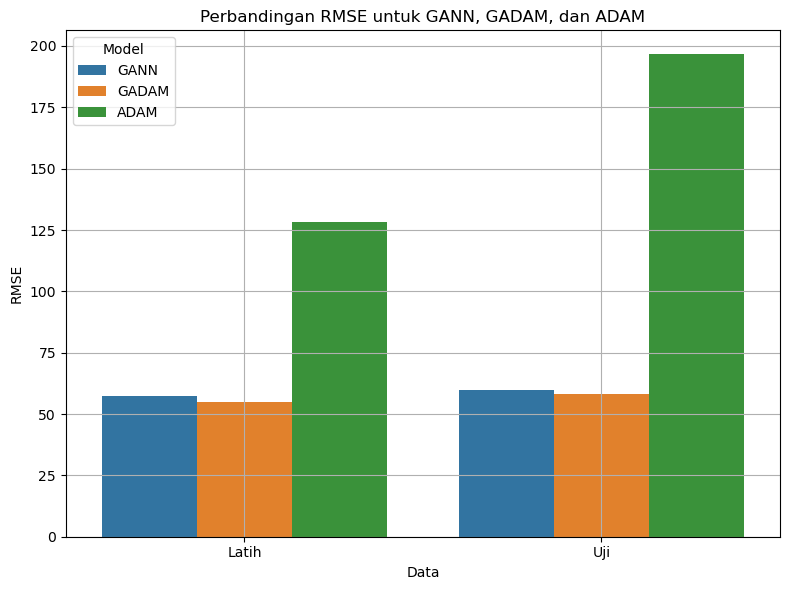

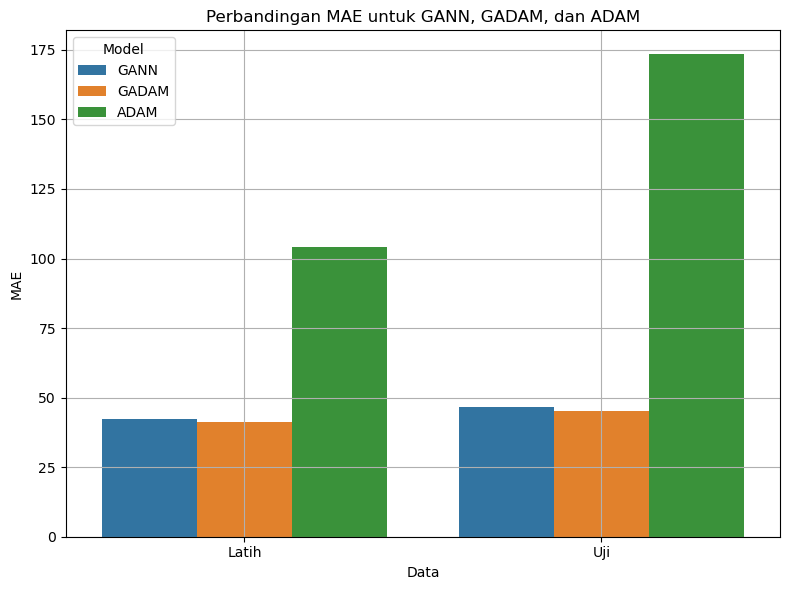

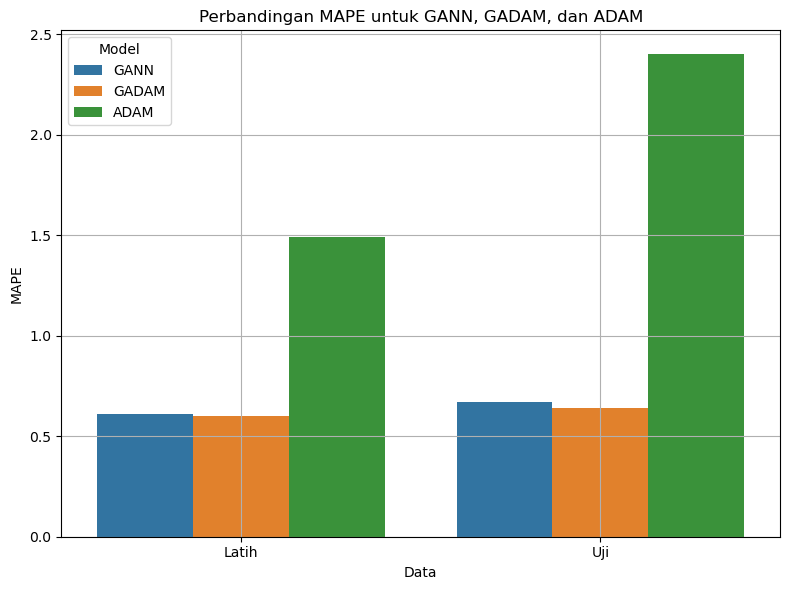

In [12]:
for metric in ['RMSE', 'MAE', 'MAPE']:
    plt.figure(figsize=(8, 6))
    sns.barplot(data=metrics_final, x='Data', y=metric, hue='Model')
    plt.title(f'Perbandingan {metric} untuk GANN, GADAM, dan ADAM')
    plt.xlabel('Data')
    plt.ylabel(metric)
    plt.legend(title='Model')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'ihsg_metrics_comparison_{metric.lower()}.png')
    plt.show()